In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import re

In [2]:
#Cargamos los 4 trimestres
BASE_ROOT = Path(".")
quarters = ["Q1", "Q2", "Q3", "Q4"]
all_pairs = []

for q in quarters:
    # Sacamos el prefijo en minúscula (q1, q2, q3, q4)
    prefijo = q.lower()
    
    # Ruta adaptada a tu estructura exacta:
    # Ej: Proyecto_FAERS/Q1/data_processed/q1_2025_sample100k
    carpeta_trimestre = f"{prefijo}_2025_sample100k"
    base = BASE_ROOT / q / "data_processed" / carpeta_trimestre
    
    reports = pd.read_csv(base/f"{prefijo}_reports_100k.csv", dtype={"safetyreportid": str})
    drugs = pd.read_csv(base/f"{prefijo}_drugs_100k.csv", dtype={"safetyreportid": str})
    reactions = pd.read_csv(base/f"{prefijo}_reactions_100k.csv", dtype={"safetyreportid": str})

    # Limpieza
    for col in ["medicinalproduct", "activesubstancename"]:
        drugs[col] = drugs[col].astype("string").str.strip().str.upper()
        
    reactions["reaction_pt"] = reactions["reaction_pt"].astype("string").str.strip().str.upper()

    #D principal: sustancia activa
    drugs["drug_key"] = drugs["activesubstancename"].fillna(drugs["medicinalproduct"])
    drugs["drug_key"] = drugs["drug_key"].str.strip().str.upper()

    # Deduplicar dentro de cada reporte
    drugs_u = drugs[["safetyreportid", "drug_key"]].dropna().drop_duplicates()
    reac_u = reactions[["safetyreportid", "reaction_pt"]].dropna().drop_duplicates()

    #Pares por trimestre
    pairs = drugs_u.merge(reac_u, on="safetyreportid", how="inner")
    pairs["quarter"] = q.upper()

    #Guardar pares del trimestre
    pairs.to_csv(base/f"{prefijo}_pairs_100k.csv", index=False)
    all_pairs.append(pairs)

# Unimos los 4 tris
pairs_2025_q1q4 = pd.concat(all_pairs, ignore_index=True)
out_path = BASE_ROOT / "pairs_2025_q1q4_400k.csv"
pairs_2025_q1q4.to_csv(out_path, index=False)

print("Saved combined pairs:", out_path)
print("rows:", len(pairs_2025_q1q4))
print("unique drugs:", pairs_2025_q1q4["drug_key"].nunique())
print("unique reactions:", pairs_2025_q1q4["reaction_pt"].nunique())
print("quarters counts:\n", pairs_2025_q1q4["quarter"].value_counts())

Saved combined pairs: pairs_2025_q1q4_400k.csv
rows: 10954199
unique drugs: 25107
unique reactions: 13099
quarters counts:
 quarter
Q3    2878325
Q4    2872625
Q1    2837090
Q2    2366159
Name: count, dtype: int64


In [3]:
df = pairs_2025_q1q4.copy()

# Universo GLOBAL de informes
N = df["safetyreportid"].nunique()

# deduplicar a nivel de informe para conteos marginales
dfD = df.drop_duplicates(["safetyreportid", "drug_key"])
dfA = df.drop_duplicates(["safetyreportid", "reaction_pt"])

# Conteos básicos:
# n11: # reportes donde aparece (D,A)
n11 = (df.groupby(["drug_key", "reaction_pt"])
       .size()
       .rename("n11")
       .reset_index())

# n1dot: # reportes donde aparece D (cualquier A)
n1dot = (dfD.groupby("drug_key")
         .size()
         .rename("n1dot")
         .reset_index())

# ndot1: # reportes donde aparece A (cualquier D)
ndot1 = (dfA.groupby("reaction_pt")
         .size()
         .rename("ndot1")
         .reset_index())

# Creamos tabla 2x2 por par
sig = (n11.merge(n1dot, on="drug_key", how="left")
       .merge(ndot1, on="reaction_pt", how="left"))

sig["N"] = int(N)
sig["n10"] = sig["n1dot"] - sig["n11"] # D sin A
sig["n01"] = sig["ndot1"] - sig["n11"] # A sin D
sig["n00"] = sig["N"] - sig["n11"] - sig["n10"] - sig["n01"] # ni D ni A

# filtro mínimo de soporte
MIN_N11 = 5
sig = sig[sig["n11"] >= MIN_N11].copy()

# ROR + IC95% (con corrección 0.5 tipo Haldane-Anscombe para evitar division by zero)
a = sig["n11"].astype(float) + 0.5
b = sig["n10"].astype(float) + 0.5
c = sig["n01"].astype(float) + 0.5
d = sig["n00"].astype(float) + 0.5

sig["ROR"] = (a * d) / (b * c)
sig["SE_logROR"] = np.sqrt(1/a + 1/b + 1/c + 1/d)
sig["ROR_L95"] = np.exp(np.log(sig["ROR"]) - 1.96 * sig["SE_logROR"])
sig["ROR_U95"] = np.exp(np.log(sig["ROR"]) + 1.96 * sig["SE_logROR"])

# PRR (solo para comparar)
sig["PRR"] = (sig["n11"] / (sig["n11"] + sig["n10"])) / (sig["n01"] / (sig["n01"] + sig["n00"]))

# Ranking para priorizar los pares con ROR_L95 > 1 y luego ROR
sig["is_signal"] = sig["ROR_L95"] > 1
sig = sig.sort_values(["is_signal", "ROR"], ascending=[False, False])

print("N reports:", N)
print("signals rows:", len(sig))
sig.head()

/home/violeta/Escritorio/Proyecto_FAERS/env/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/violeta/Escritorio/Proyecto_FAERS/env/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


N reports: 390140
signals rows: 312347


,drug_key,reaction_pt,n11,n1dot,ndot1,N,n10,n01,n00,ROR,SE_logROR,ROR_L95,ROR_U95,PRR,is_signal
1217743,PENFLURIDOL,PAROXYSMAL PERCEPTUAL ALTERATION,6,6,7,390140,0,1,390133,3381157.0,1.679439,125747.104223,9.091440e+07,390134.0,True
1197447,PANTOPRAZOL CT,HAEMANGIOMA OF BONE,6,6,8,390140,0,2,390132,2028689.0,1.598077,88492.249985,4.650779e+07,195067.0,True
1217742,PENFLURIDOL,OSCILLOPSIA,6,6,8,390140,0,2,390132,2028689.0,1.598077,88492.249985,4.650779e+07,195067.0,True
1118799,NIKETHAMIDE,NEUROGLYCOPENIA,5,7,5,390140,2,0,390133,1716587.4,1.606805,73608.218392,4.003184e+07,inf,True
1481637,THERABREATH,VERTEBRAL LATERAL RECESS STENOSIS,5,5,7,390140,0,2,390133,1716587.4,1.606805,73608.218392,4.003184e+07,195067.5,True


In [10]:
# Creamos la carpeta por si se necesita guardar después
out_dir = Path("data_processed")
out_dir.mkdir(parents=True, exist_ok=True)

# Solo señales positivas (Límite inferior del IC95% > 1)
sig_pos = sig[sig["ROR_L95"] > 1].copy()
#minimo 10
MIN_N11_STRICT = 10
sig_pos = sig_pos[sig_pos["n11"] >= MIN_N11_STRICT].copy()

# Ranking final (por ROR_L95, luego ROR, luego n11)
sig_pos = sig_pos.sort_values(["ROR_L95", "ROR", "n11"], ascending=[False, False, False])

In [11]:
sig_pos

,drug_key,reaction_pt,n11,n1dot,ndot1,N,n10,n01,n00,ROR,SE_logROR,ROR_L95,ROR_U95,PRR,is_signal
1003317,MENTHOL,EXPOSURE TO CHEMICAL POLLUTION,185,253,188,390140,68,3,389884,301662.459854,0.552907,102065.101083,8.915902e+05,95031.745718,True
66520,ALEFACEPT,NEUROLOGIC NEGLECT SYNDROME,25,27,36,390140,2,11,390102,346003.956522,0.725379,83488.363671,1.433957e+06,32837.794613,True
717370,FURAZOLIDONE,SLEEP DISORDER THERAPY,23,31,26,390140,8,3,390106,308151.352941,0.667770,83242.779197,1.140727e+06,96478.569892,True
66494,ALEFACEPT,CAROTID ARTERY THROMBOSIS,26,27,41,390140,1,15,390098,444628.397849,0.876882,79722.438569,2.479784e+06,25044.291358,True
206801,BETA GLUCAN,TOTAL LUNG CAPACITY ABNORMAL,29,36,35,390140,7,6,390098,236059.605128,0.566640,77747.847095,7.167290e+05,52375.074074,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228393,BISOPROLOL,HYPOACUSIS,11,2527,997,390140,2516,986,386627,1.791004,0.297271,1.000125,3.207295e+00,1.711232,True
1357215,RIVAROXABAN,RESPIRATORY FAILURE,12,2238,1253,390140,2226,1241,386661,1.748524,0.285056,1.000061,3.057148e+00,1.675990,True
1457028,TAMSULOSIN,INFLUENZA,26,1892,3741,390140,1866,3715,384533,1.469382,0.196325,1.000046,2.158985e+00,1.436159,True
954089,LOPERAMIDE HYDROCHLORIDE,INJECTION SITE BRUISING,11,1326,1900,390140,1315,1889,386925,1.790142,0.297067,1.000044,3.204465e+00,1.707494,True


In [ ]:
#A mi me salieron otros farmacos 

In [13]:
# versión clínica
admin_patterns = [
    "OFF LABEL USE",
    "DRUG INEFFECTIVE",
    "PRODUCT USE IN UNAPPROVED INDICATION",
    "PRODUCT USE ISSUE",
    "INTENTIONAL PRODUCT USE ISSUE",
    "PRODUCT USE COMPLAINT",
    "DRUG INEFFECTIVE FOR UNAPPROVED INDICATION",
    "THERAPEUTIC PRODUCT EFFECT INCOMPLETE",
    "THERAPEUTIC PRODUCT EFFECT DECREASED",
    "THERAPEUTIC RESPONSE DECREASED",
    "THERAPEUTIC RESPONSE SHORTENED",
    "PRODUCT DOSE OMISSION ISSUE",
    "INAPPROPRIATE SCHEDULE OF PRODUCT ADMINISTRATION",
    "CONTRAINDICATED PRODUCT ADMINISTERED",
    "INTENTIONAL PRODUCT MISUSE",
    "MEDICATION ERROR",
    "INCORRECT ROUTE OF PRODUCT ADMINISTRATION",
    "INCORRECT PRODUCT ADMINISTRATION DURATION",
    "INTENTIONAL DOSE OMISSION",
    "PRODUCT DOSE OMISSION IN ERROR",
    "WRONG TECHNIQUE IN PRODUCT USAGE PROCESS",
    "PRODUCT ADMINISTRATION INTERRUPTED",
    "PRODUCT QUALITY ISSUE",
    "PRODUCT LABEL CONFUSION",
    "PRODUCT DISTRIBUTION ISSUE",
    "DEVICE ISSUE"
]

# Creamos la máscara para identificar estos términos (In [85])
mask_admin = sig_pos["reaction_pt"].str.contains("|".join(admin_patterns), case=False, na=False)

In [14]:
# Verificamos qué términos administrativos detectó la máscara (Página 6)
sig_pos.loc[mask_admin, "reaction_pt"].value_counts()

reaction_pt
OFF LABEL USE                                                         996
DRUG INEFFECTIVE                                                      923
PRODUCT USE IN UNAPPROVED INDICATION                                  573
PRODUCT USE ISSUE                                                     546
PRODUCT DOSE OMISSION ISSUE                                           482
THERAPEUTIC PRODUCT EFFECT INCOMPLETE                                 430
INAPPROPRIATE SCHEDULE OF PRODUCT ADMINISTRATION                      429
INTENTIONAL PRODUCT USE ISSUE                                         396
CONTRAINDICATED PRODUCT ADMINISTERED                                  323
INTENTIONAL PRODUCT MISUSE                                            302
THERAPEUTIC PRODUCT EFFECT DECREASED                                  279
MEDICATION ERROR                                                      264
INCORRECT ROUTE OF PRODUCT ADMINISTRATION                             259
PRODUCT QUALITY ISSUE     

In [15]:
sig_pos_clin = sig_pos[~mask_admin].copy()
sig_pos_clin

,drug_key,reaction_pt,n11,n1dot,ndot1,N,n10,n01,n00,ROR,SE_logROR,ROR_L95,ROR_U95,PRR,is_signal
1003317,MENTHOL,EXPOSURE TO CHEMICAL POLLUTION,185,253,188,390140,68,3,389884,301662.459854,0.552907,102065.101083,8.915902e+05,95031.745718,True
66520,ALEFACEPT,NEUROLOGIC NEGLECT SYNDROME,25,27,36,390140,2,11,390102,346003.956522,0.725379,83488.363671,1.433957e+06,32837.794613,True
717370,FURAZOLIDONE,SLEEP DISORDER THERAPY,23,31,26,390140,8,3,390106,308151.352941,0.667770,83242.779197,1.140727e+06,96478.569892,True
66494,ALEFACEPT,CAROTID ARTERY THROMBOSIS,26,27,41,390140,1,15,390098,444628.397849,0.876882,79722.438569,2.479784e+06,25044.291358,True
206801,BETA GLUCAN,TOTAL LUNG CAPACITY ABNORMAL,29,36,35,390140,7,6,390098,236059.605128,0.566640,77747.847095,7.167290e+05,52375.074074,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228393,BISOPROLOL,HYPOACUSIS,11,2527,997,390140,2516,986,386627,1.791004,0.297271,1.000125,3.207295e+00,1.711232,True
1357215,RIVAROXABAN,RESPIRATORY FAILURE,12,2238,1253,390140,2226,1241,386661,1.748524,0.285056,1.000061,3.057148e+00,1.675990,True
1457028,TAMSULOSIN,INFLUENZA,26,1892,3741,390140,1866,3715,384533,1.469382,0.196325,1.000046,2.158985e+00,1.436159,True
954089,LOPERAMIDE HYDROCHLORIDE,INJECTION SITE BRUISING,11,1326,1900,390140,1315,1889,386925,1.790142,0.297067,1.000044,3.204465e+00,1.707494,True


In [16]:
#EMPIZA LA CATEGORIZACION DE SEVERIDAD


In [17]:
dummy_patterns = [
    "EXPOSURE TO",
    "DRUG EXPOSURE",
    "PRODUCT EXPOSURE",
    "EXPOSURE DURING PREGNANCY",
    "EXPOSURE DURING BREASTFEEDING",
    "OCCUPATIONAL EXPOSURE",
    "ENVIRONMENTAL EXPOSURE",
    "CHEMICAL POLLUTION",
    "DRUG LEVEL",
    "BLOOD DRUG LEVEL",
    "DRUG MONITORING",
    "DRUG SCREEN",
    "SCREENING",
    "TEST",
    "PROCEDURE",
]

dummy_pattern = r"(?:{})".format("|".join(map(re.escape, dummy_patterns)))

sig_pos_clin["is_dummy_exposure"] = sig_pos_clin["reaction_pt"].str.contains(
    dummy_pattern,
    case=False,
    na=False,
    regex=True
)


# Eventos claramente graves (muerte, fallo orgánico, congénitos, choque, etc.)
severe_keywords = [
    "DEATH",
    "CARDIAC ARREST",
    "MYOCARDIAL INFARCTION",
    "STROKE",
    "CEREBRAL HAEMORRHAGE",
    "CEREBRAL HEMORRHAGE",
    "HEMORRHAGE",
    "HAEMORRHAGE",
    "SHOCK",
    "ANAPHYLACTIC",
    "ANAPHYLAXIS",
    "RESPIRATORY FAILURE",
    "CARDIAC FAILURE",
    "RENAL FAILURE",
    "KIDNEY FAILURE",
    "HEPATIC FAILURE",
    "LIVER FAILURE",
    "CONGENITAL",
    "MALFORMATION",
    "SEPSIS",
    "SEPTIC",
    "COMA",
    "TORSADES",
    "VENTRICULAR FIBRILLATION",
]

# Eventos leves/moderados (síntomas frecuentes, molestos pero no catastróficos)
mild_keywords = [
    "HEADACHE",
    "NAUSEA",
    "VOMITING",
    "DIARRHOEA",
    "DIARRHEA",
    "DIZZINESS",
    "RASH",
    "PRURITUS",
    "URTICARIA",
    "DRY MOUTH",
    "FATIGUE",
    "FLATULENCE",
    "VAGINAL FLATULENCE",
    "INSOMNIA",
    "POOR QUALITY SLEEP",
    "SOMNOLENCE",
    "HICCUPS",
    "COUGH",
    "PRODUCTIVE COUGH",
]

In [18]:
def classify_severity(pt, is_dummy):

    #Clasifica en: 'Dummy/Exposure' 'Severe''Moderate/Mild' 'Unclear'
    text = str(pt).upper()
    
    # Dummy / exposición: no es un evento clínico en sí
    if is_dummy:
        return "Dummy/Exposure"
    
    # Eventos grave por palabra clave en el PT
    if any(kw in text for kw in severe_keywords):
        return "Severe"
    
    # Eventos típicamente leves o moderados
    if any(kw in text for kw in mild_keywords):
        return "Moderate/Mild"
    
    # Si no encaja en nada, lo dejamos como 'Unclear'
    return "Unclear"

sig_pos_clin["severity_category"] = sig_pos_clin.apply(
    lambda row: classify_severity(row["reaction_pt"], row["is_dummy_exposure"]),
    axis=1
)
sig_pos_clin.head()

,drug_key,reaction_pt,n11,n1dot,ndot1,N,n10,n01,n00,ROR,SE_logROR,ROR_L95,ROR_U95,PRR,is_signal,is_dummy_exposure,severity_category
1003317,MENTHOL,EXPOSURE TO CHEMICAL POLLUTION,185,253,188,390140,68,3,389884,301662.459854,0.552907,102065.101083,8.915902e+05,95031.745718,True,True,Dummy/Exposure
66520,ALEFACEPT,NEUROLOGIC NEGLECT SYNDROME,25,27,36,390140,2,11,390102,346003.956522,0.725379,83488.363671,1.433957e+06,32837.794613,True,False,Unclear
717370,FURAZOLIDONE,SLEEP DISORDER THERAPY,23,31,26,390140,8,3,390106,308151.352941,0.667770,83242.779197,1.140727e+06,96478.569892,True,False,Unclear
66494,ALEFACEPT,CAROTID ARTERY THROMBOSIS,26,27,41,390140,1,15,390098,444628.397849,0.876882,79722.438569,2.479784e+06,25044.291358,True,False,Unclear
206801,BETA GLUCAN,TOTAL LUNG CAPACITY ABNORMAL,29,36,35,390140,7,6,390098,236059.605128,0.566640,77747.847095,7.167290e+05,52375.074074,True,False,Unclear


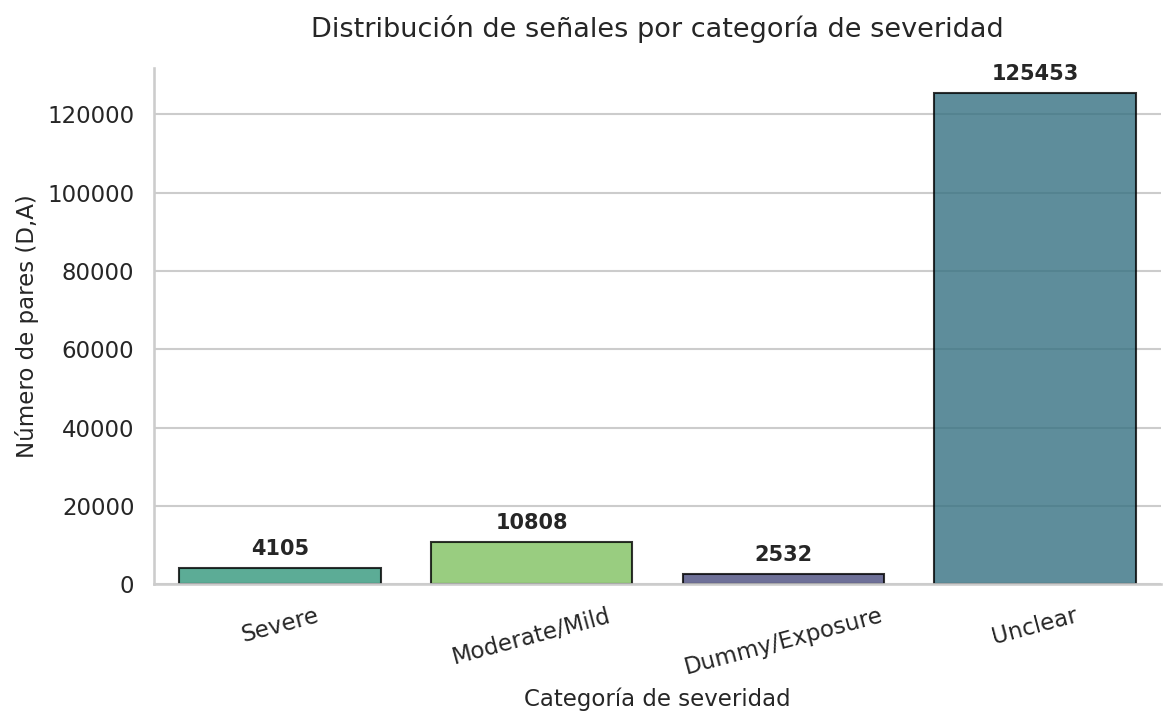

In [22]:
#incluyendo unclear
plt.figure(figsize=(8, 5), dpi=150)
order_all = ["Severe", "Moderate/Mild", "Dummy/Exposure", "Unclear"]

sns.set_theme(style="whitegrid")
ax1 = sns.countplot(
    data=sig_pos_clin,
    x="severity_category",
    order=order_all,
    hue="severity_category", #asignamos la variable al color
    palette="viridis",
    legend=False,            
    edgecolor="black",
    alpha=0.8
)

# Etiquetas de datos
for p in ax1.patches:
    if p.get_height() > 0:
        ax1.annotate(f'{int(p.get_height())}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points',
                     fontsize=10, fontweight='bold')

plt.title("Distribución de señales por categoría de severidad", fontsize=13, pad=15)
plt.xlabel("Categoría de severidad", fontsize=11)
plt.ylabel("Número de pares (D,A)", fontsize=11)
plt.xticks(rotation=15)
sns.despine()
plt.tight_layout()
plt.show()

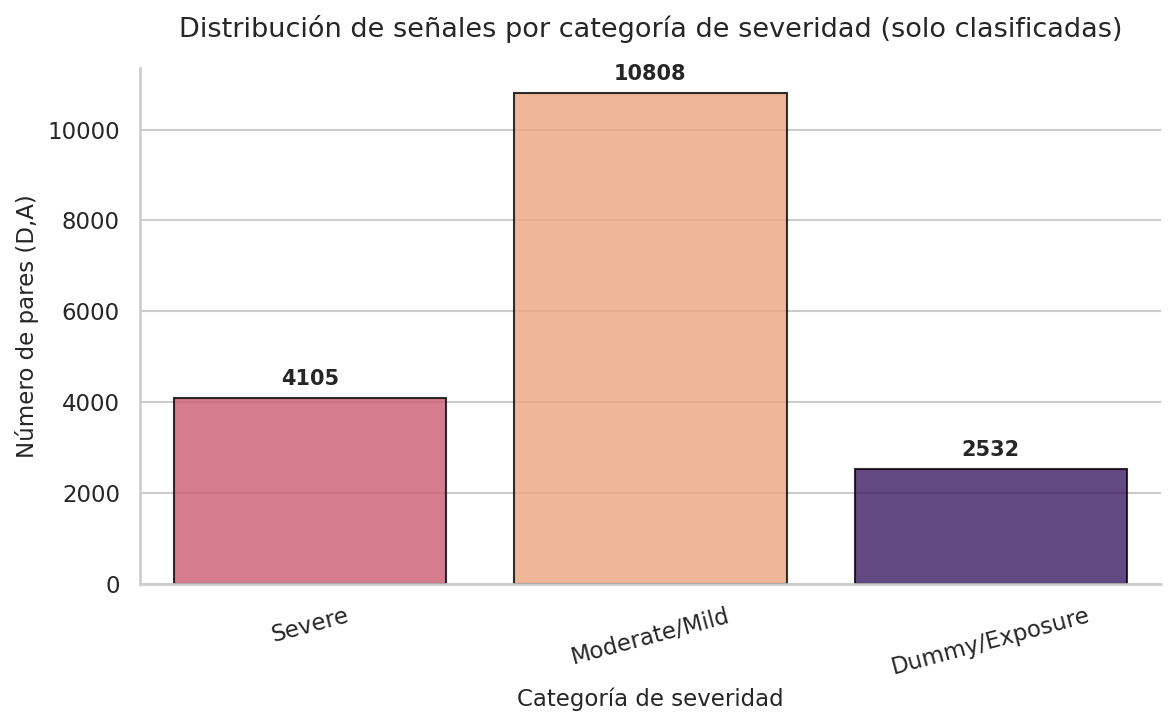

In [23]:
#sin unclear
# --- GRÁFICA 2: SOLO CLASIFICADAS ---
plt.figure(figsize=(8, 5), dpi=150)
order_clin = ["Severe", "Moderate/Mild", "Dummy/Exposure"]

ax2 = sns.countplot(
    data=sig_pos_clin,
    x="severity_category",
    order=order_clin,
    hue="severity_category", # Corregido
    palette="magma",
    legend=False,            # Corregido
    edgecolor="black",
    alpha=0.8
)

# Etiquetas de datos
for p in ax2.patches:
    if p.get_height() > 0:
        ax2.annotate(f'{int(p.get_height())}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points',
                     fontsize=10, fontweight='bold')

plt.title("Distribución de señales por categoría de severidad (solo clasificadas)", fontsize=13, pad=15)
plt.xlabel("Categoría de severidad", fontsize=11)
plt.ylabel("Número de pares (D,A)", fontsize=11)
plt.xticks(rotation=15)
sns.despine()
plt.tight_layout()
plt.show()

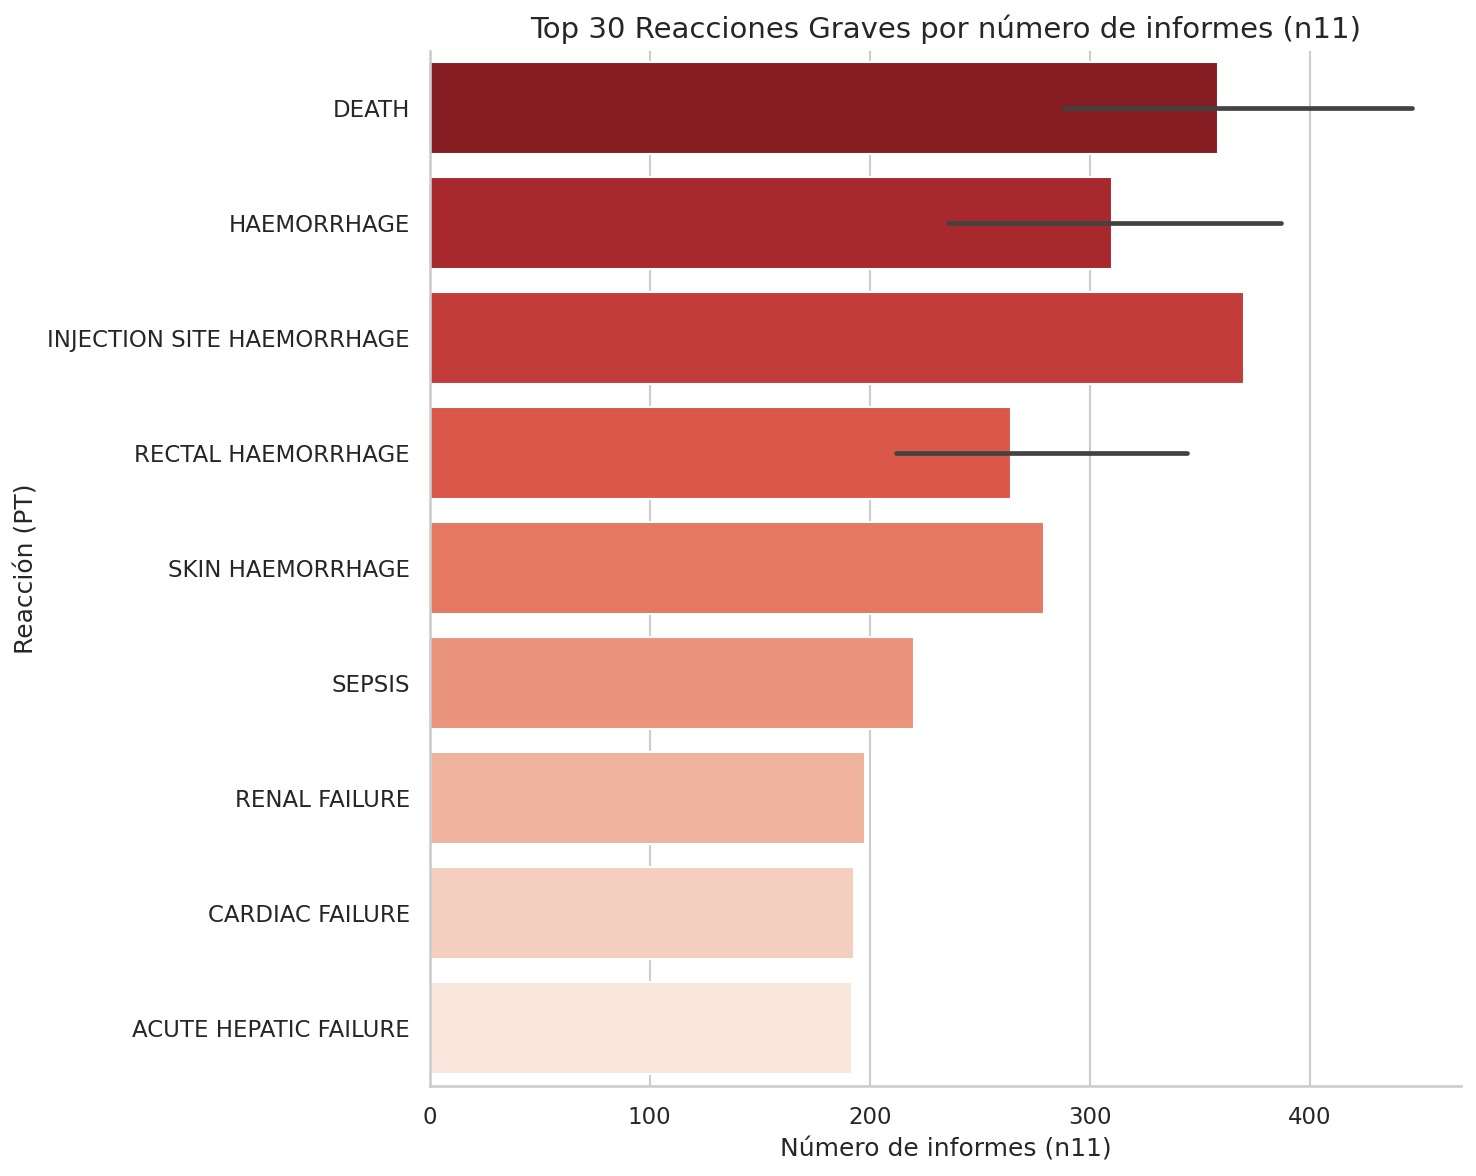

In [24]:

top_severe = sig_pos_clin[sig_pos_clin["severity_category"] == "Severe"].sort_values("n11", ascending=False).head(30)

plt.figure(figsize=(10, 8), dpi=150)

#Ponemos un fondo de cuadrícula blancapara ver lineas
sns.set_theme(style="whitegrid")
sns.barplot(data=top_severe, x="n11", y="reaction_pt", palette="Reds_r", hue="reaction_pt", legend=False)
plt.title("Top 30 Reacciones Graves por número de informes (n11)", fontsize=14)
plt.xlabel("Número de informes (n11)", fontsize=12)
plt.ylabel("Reacción (PT)", fontsize=12)

#Quitamos los bordes de arriba y de la derecha para que se vea más limpia
sns.despine()
#Ajustamos todo para que no se corten los nombres
plt.tight_layout()

plt.show()

In [25]:
#SEÑALES CLINICAS RELEVANTES

In [26]:
#solo señales clínicas relevantes
main_severity = ["Severe", "Moderate/Mild"]

mask_main = sig_pos_clin["severity_category"].isin(main_severity)
sig_pos_main = sig_pos_clin[mask_main].copy()

sig_pos_main["severity_category"].value_counts()


severity_category
Moderate/Mild    10808
Severe            4105
Name: count, dtype: int64

In [27]:
#aqui igula cambia un poco , aqui severe es de 4105 y en el del Profe es de 3778

In [28]:
sig_pos_main.head()

,drug_key,reaction_pt,n11,n1dot,ndot1,N,n10,n01,n00,ROR,SE_logROR,ROR_L95,ROR_U95,PRR,is_signal,is_dummy_exposure,severity_category
539800,DOLUTEGRAVIR\LAMIVUDINE\TENOFOVIR DISOPROXIL F...,CONGENITAL UMBILICAL HERNIA,14,25,16,390140,11,2,390113,196752.895652,0.745604,45630.014568,8.483824e+05,109232.200000,True,False,Severe
274628,CALCITRIOL\CALCIUM CARBONATE\ZINC,VAGINAL FLATULENCE,16,17,33,390140,1,17,390106,245209.800000,0.885674,43215.250233,1.391357e+06,21598.505190,True,False,Moderate/Mild
394632,CLOFIBRATE,VAGINAL FLATULENCE,17,19,33,390140,2,16,390105,165499.303030,0.719549,40392.735965,6.780927e+05,21815.976974,True,False,Moderate/Mild
1418544,SODIUM STEARATE,VAGINAL FLATULENCE,14,15,33,390140,1,19,390106,193386.128205,0.887083,33987.933591,1.100337e+06,19164.035088,True,False,Moderate/Mild
1376591,SAFFLOWER,CONGENITAL HIATUS HERNIA,11,12,26,390140,1,15,390113,192959.365591,0.904512,32774.022006,1.136062e+06,23841.155556,True,False,Severe


In [29]:
#aqui es un poco similar , creo que se debe a los sample 100k

In [30]:
#Los términos de sólo exposición y no clasificados se excluyeron del análisis.
sig_excluded = sig_pos_clin[
    ~sig_pos_clin["severity_category"].isin(["Severe", "Moderate/Mild"])
].copy()

sig_excluded["severity_category"].value_counts()

severity_category
Unclear           125453
Dummy/Exposure      2532
Name: count, dtype: int64

In [31]:
#igual difiere un poco 

In [32]:
#CARACTERIZACION GLOBAL DE LAS SEÑALES

In [33]:
sig_pos_main[["n11", "n1dot", "ndot1", "N", "ROR", "ROR_L95", "ROR_U95", "PRR"]].describe(
    percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])

/home/violeta/Escritorio/Proyecto_FAERS/env/lib/python3.12/site-packages/pandas/core/nanops.py:1020: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,n11,n1dot,ndot1,N,ROR,ROR_L95,ROR_U95,PRR
count,14913.000000,14913.000000,14913.000000,14913.0,14913.000000,14913.000000,1.491300e+04,1.491300e+04
mean,64.200496,1650.523637,6733.528867,390140.0,261.870590,73.282510,1.772659e+03,inf
std,117.419235,2612.929407,5895.331480,0.0,5741.440799,951.255127,7.235966e+04,NaN
min,10.000000,10.000000,12.000000,390140.0,1.144190,1.000061,1.280662e+00,1.137591e+00
50%,26.000000,716.000000,4471.000000,390140.0,4.898106,3.393931,7.247918e+00,4.477533e+00
75%,60.000000,2144.000000,11716.000000,390140.0,14.413162,9.584597,2.197578e+01,1.172520e+01
90%,158.000000,4013.000000,14944.000000,390140.0,68.558347,40.920290,1.132048e+02,5.091782e+01
95%,260.400000,6500.000000,17129.000000,390140.0,205.181638,113.549877,3.697555e+02,1.548259e+02
99%,525.760000,13865.000000,17129.000000,390140.0,1925.613933,892.477451,4.848112e+03,1.143181e+03
max,5080.000000,34807.000000,17129.000000,390140.0,309139.415094,45630.014568,5.411687e+06,inf


In [34]:
#y ocurre lo mismo , todos tienen una cola larga, la mayoria de las alertas ocurren pocas vecespero hay un buen de alertas que ocurren miles de veces 

In [36]:
# Filtramos para quedarnos solo con lo clínico relevante (Severe y Moderate)
sig_pos_main = sig_pos_clin[sig_pos_clin["severity_category"].isin(["Severe", "Moderate/Mild"])].copy()

print("Señales final:", len(sig_pos_main))

Señales final: 14913


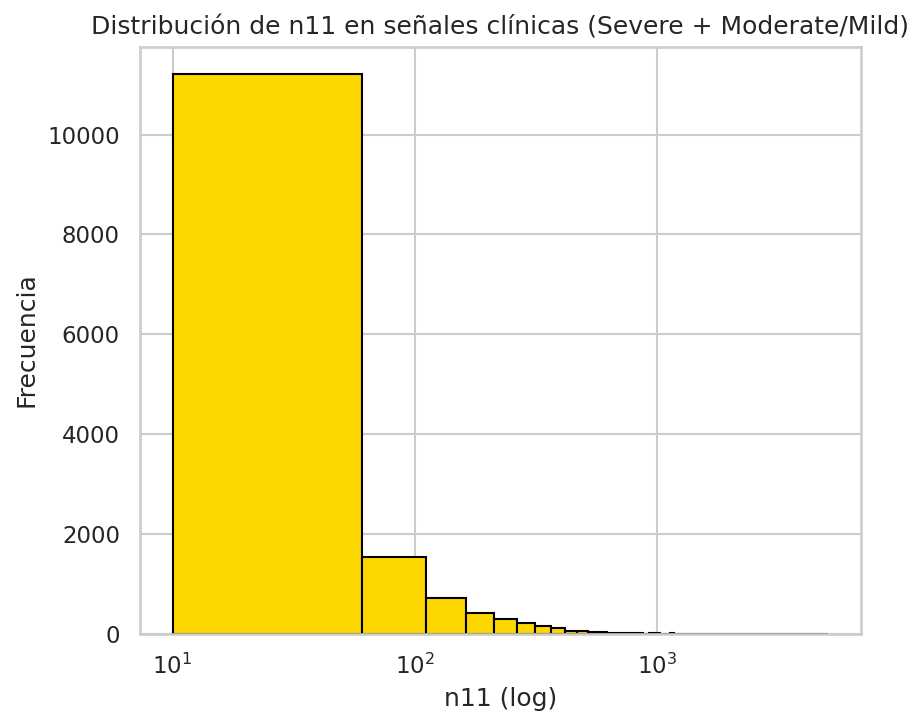

In [42]:
# Distribución de n11 (log-scale)
plt.figure(figsize=(6,5),dpi=150)
plt.hist(sig_pos_main["n11"], bins=100, color='gold',edgecolor='black')
plt.xscale("log")
plt.xlabel("n11 (log)")
plt.ylabel("Frecuencia")
plt.title("Distribución de n11 en señales clínicas (Severe + Moderate/Mild)")
plt.tight_layout()
plt.show()

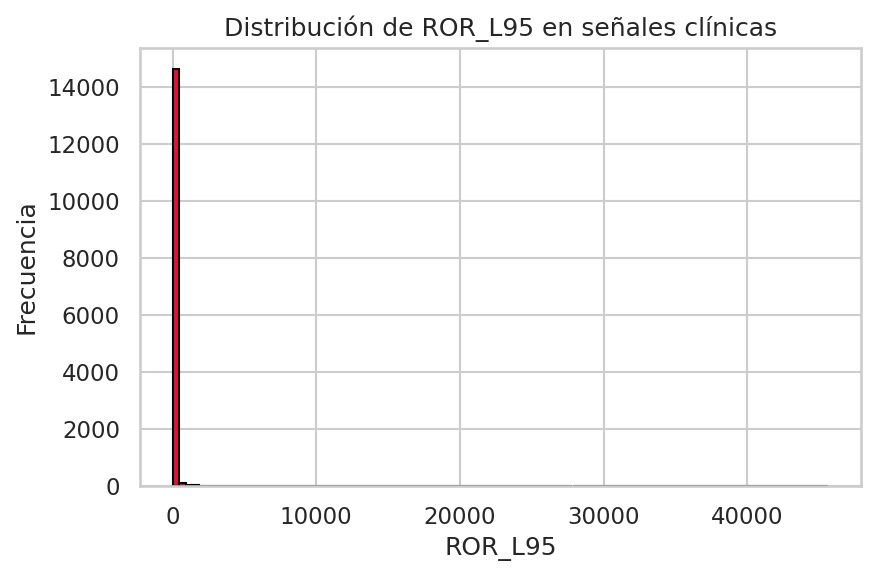

In [44]:
# Distribución de ROR_L95
plt.figure(figsize=(6,4),dpi=150)
plt.hist(sig_pos_main["ROR_L95"], bins=100, color='crimson',edgecolor='black')
plt.xlabel("ROR_L95")
plt.ylabel("Frecuencia")
#plt.ylim([0, 120])
plt.title("Distribución de ROR_L95 en señales clínicas")
plt.tight_layout()
plt.show()

In [46]:
#aqui el conjunto de señales clinicas analizadas fue de 14913 pares farmaco_reaccion clasificados como severe o mild 
#igual presneta una marca asimetrica positiva, con una cola larga como ya habia mencionado.

In [47]:
#COMPARACION SEVERE VS MILD

In [48]:
sig_pos_main.groupby("severity_category")[["n11", "ROR", "ROR_L95"]].describe()

n11                                                 \
                     count       mean         std   min   25%   50%   75%   
severity_category                                                           
Moderate/Mild      10808.0  77.858901  133.701545  10.0  16.0  30.0  83.0   
Severe              4105.0  28.239464   35.196474  10.0  13.0  19.0  31.0   

                               ROR              ...                            \
                      max    count        mean  ...        75%            max   
severity_category                               ...                             
Moderate/Mild      5080.0  10808.0  149.290271  ...  10.810426  245209.800000   
Severe              979.0   4105.0  558.281817  ...  43.301117  309139.415094   

                   ROR_L95                                               \
                     count        mean          std       min       25%   
severity_category                                                         
Moderate/Mild      10808.0   48.665449   833.416969  1.000476  1.856235   
Severe              4105.0  138.096444  1205.444017  1.000061  2.042250   

                                                      
                        50%        75%           max  
severity_category                                     
Moderate/Mild      3.136577   7.436401  43215.250233  
Severe             4.891792  26.783455  45630.014568  

[2 rows x 24 columns]

In [49]:
#aqui podemos ver que los que son de gravedad ocurren menos veces 4105
#mientras que las moderadas un 10,808 los pacientes reportan mas nauseas y dolores de cabeza por ejemplo

<Figure size 750x600 with 0 Axes>

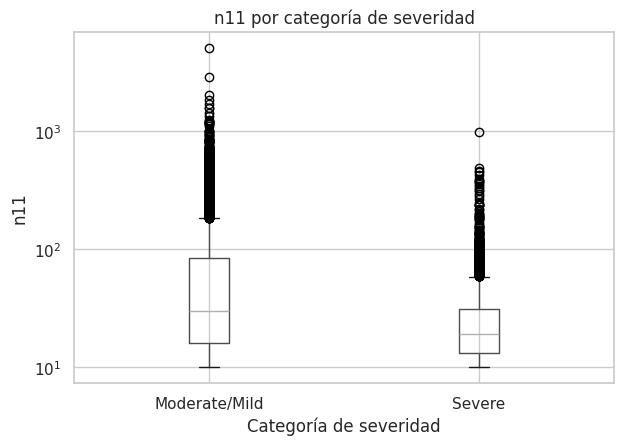

<Figure size 750x600 with 0 Axes>

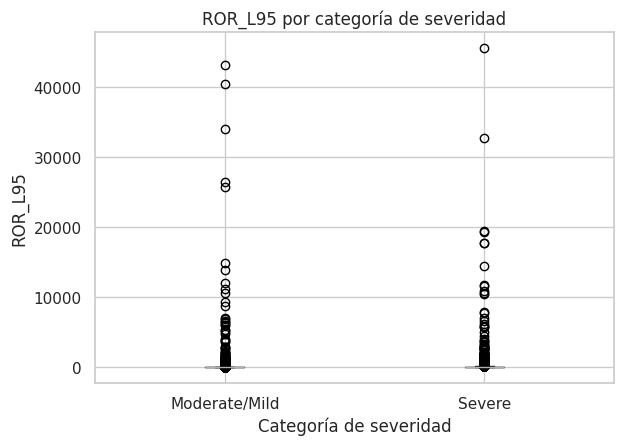

In [51]:
for col in ["n11", "ROR_L95"]:
    plt.figure(figsize=(5,4),dpi=150)
    sig_pos_main.boxplot(column=col, by="severity_category")
    if col == "n11":
        plt.yscale("log")
    plt.title(f"{col} por categoría de severidad")
    plt.suptitle("")
    plt.xlabel("Categoría de severidad")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

In [54]:
#Las gráficas demuestran que, aunque la mayoría de las señales en FAERS tienen 
#frecuencias y riesgos moderados, el análisis identifica con precisión una 'cola larga' de valores atípicos 
#(outliers) con señales de riesgo extremadamente altas
#que representan las alertas más críticas para la seguridad del paciente.

In [55]:
#SCORE DE PRIORIDAD

In [56]:
sig_pos_main["priority_score"] = np.log(sig_pos_main["ROR_L95"]) * np.log(sig_pos_main["n11"])

In [57]:
top_severe = (
    sig_pos_main[sig_pos_main["severity_category"] == "Severe"]
    .sort_values("priority_score", ascending=False)
    .head(50)
)
top_severe[["drug_key", "reaction_pt", "n11", "ROR_L95", "priority_score"]].head(10)

,drug_key,reaction_pt,n11,ROR_L95,priority_score
922295,LEVONORGESTREL,GENITAL HAEMORRHAGE,107,901.678399,31.795133
582190,EMICIZUMAB-KXWH,HAEMORRHAGE,380,201.087277,31.505118
206781,BETA GLUCAN,PULMONARY ALVEOLAR HAEMORRHAGE,32,7874.872799,31.092615
756802,HAIR KERATIN AMINO ACIDS GOLD COMPLEX,CONGENITAL ANOMALY,50,1909.515955,29.553789
747337,GOLD SODIUM THIOMALATE,CONGENITAL ANOMALY,72,918.234865,29.177354
539800,DOLUTEGRAVIR\LAMIVUDINE\TENOFOVIR DISOPROXIL F...,CONGENITAL UMBILICAL HERNIA,14,45630.014568,28.312654
896140,LECANEMAB-IRMB,AMYLOID RELATED IMAGING ABNORMALITY-MICROHAEMO...,57,903.506335,27.518152
792579,HYDROCORTISONE PROBUTATE,CONGENITAL ANOMALY,44,1278.394072,27.069671
896939,LEDIPASVIR,HAEMORRHAGIC STROKE,21,6998.571942,26.954562
371472,CILAZAPRIL ANHYDROUS,HAEMORRHAGIC STROKE,21,6189.649591,26.580610


In [58]:
#aqui ya se van pareciendo las cosas un poco mas en levonorgestrel tenemos 107 casos igulamnete y un ror del 901.67 que es enorme
#bueno el Limite inferior del 95, cambian algunos farmacos de igual forma

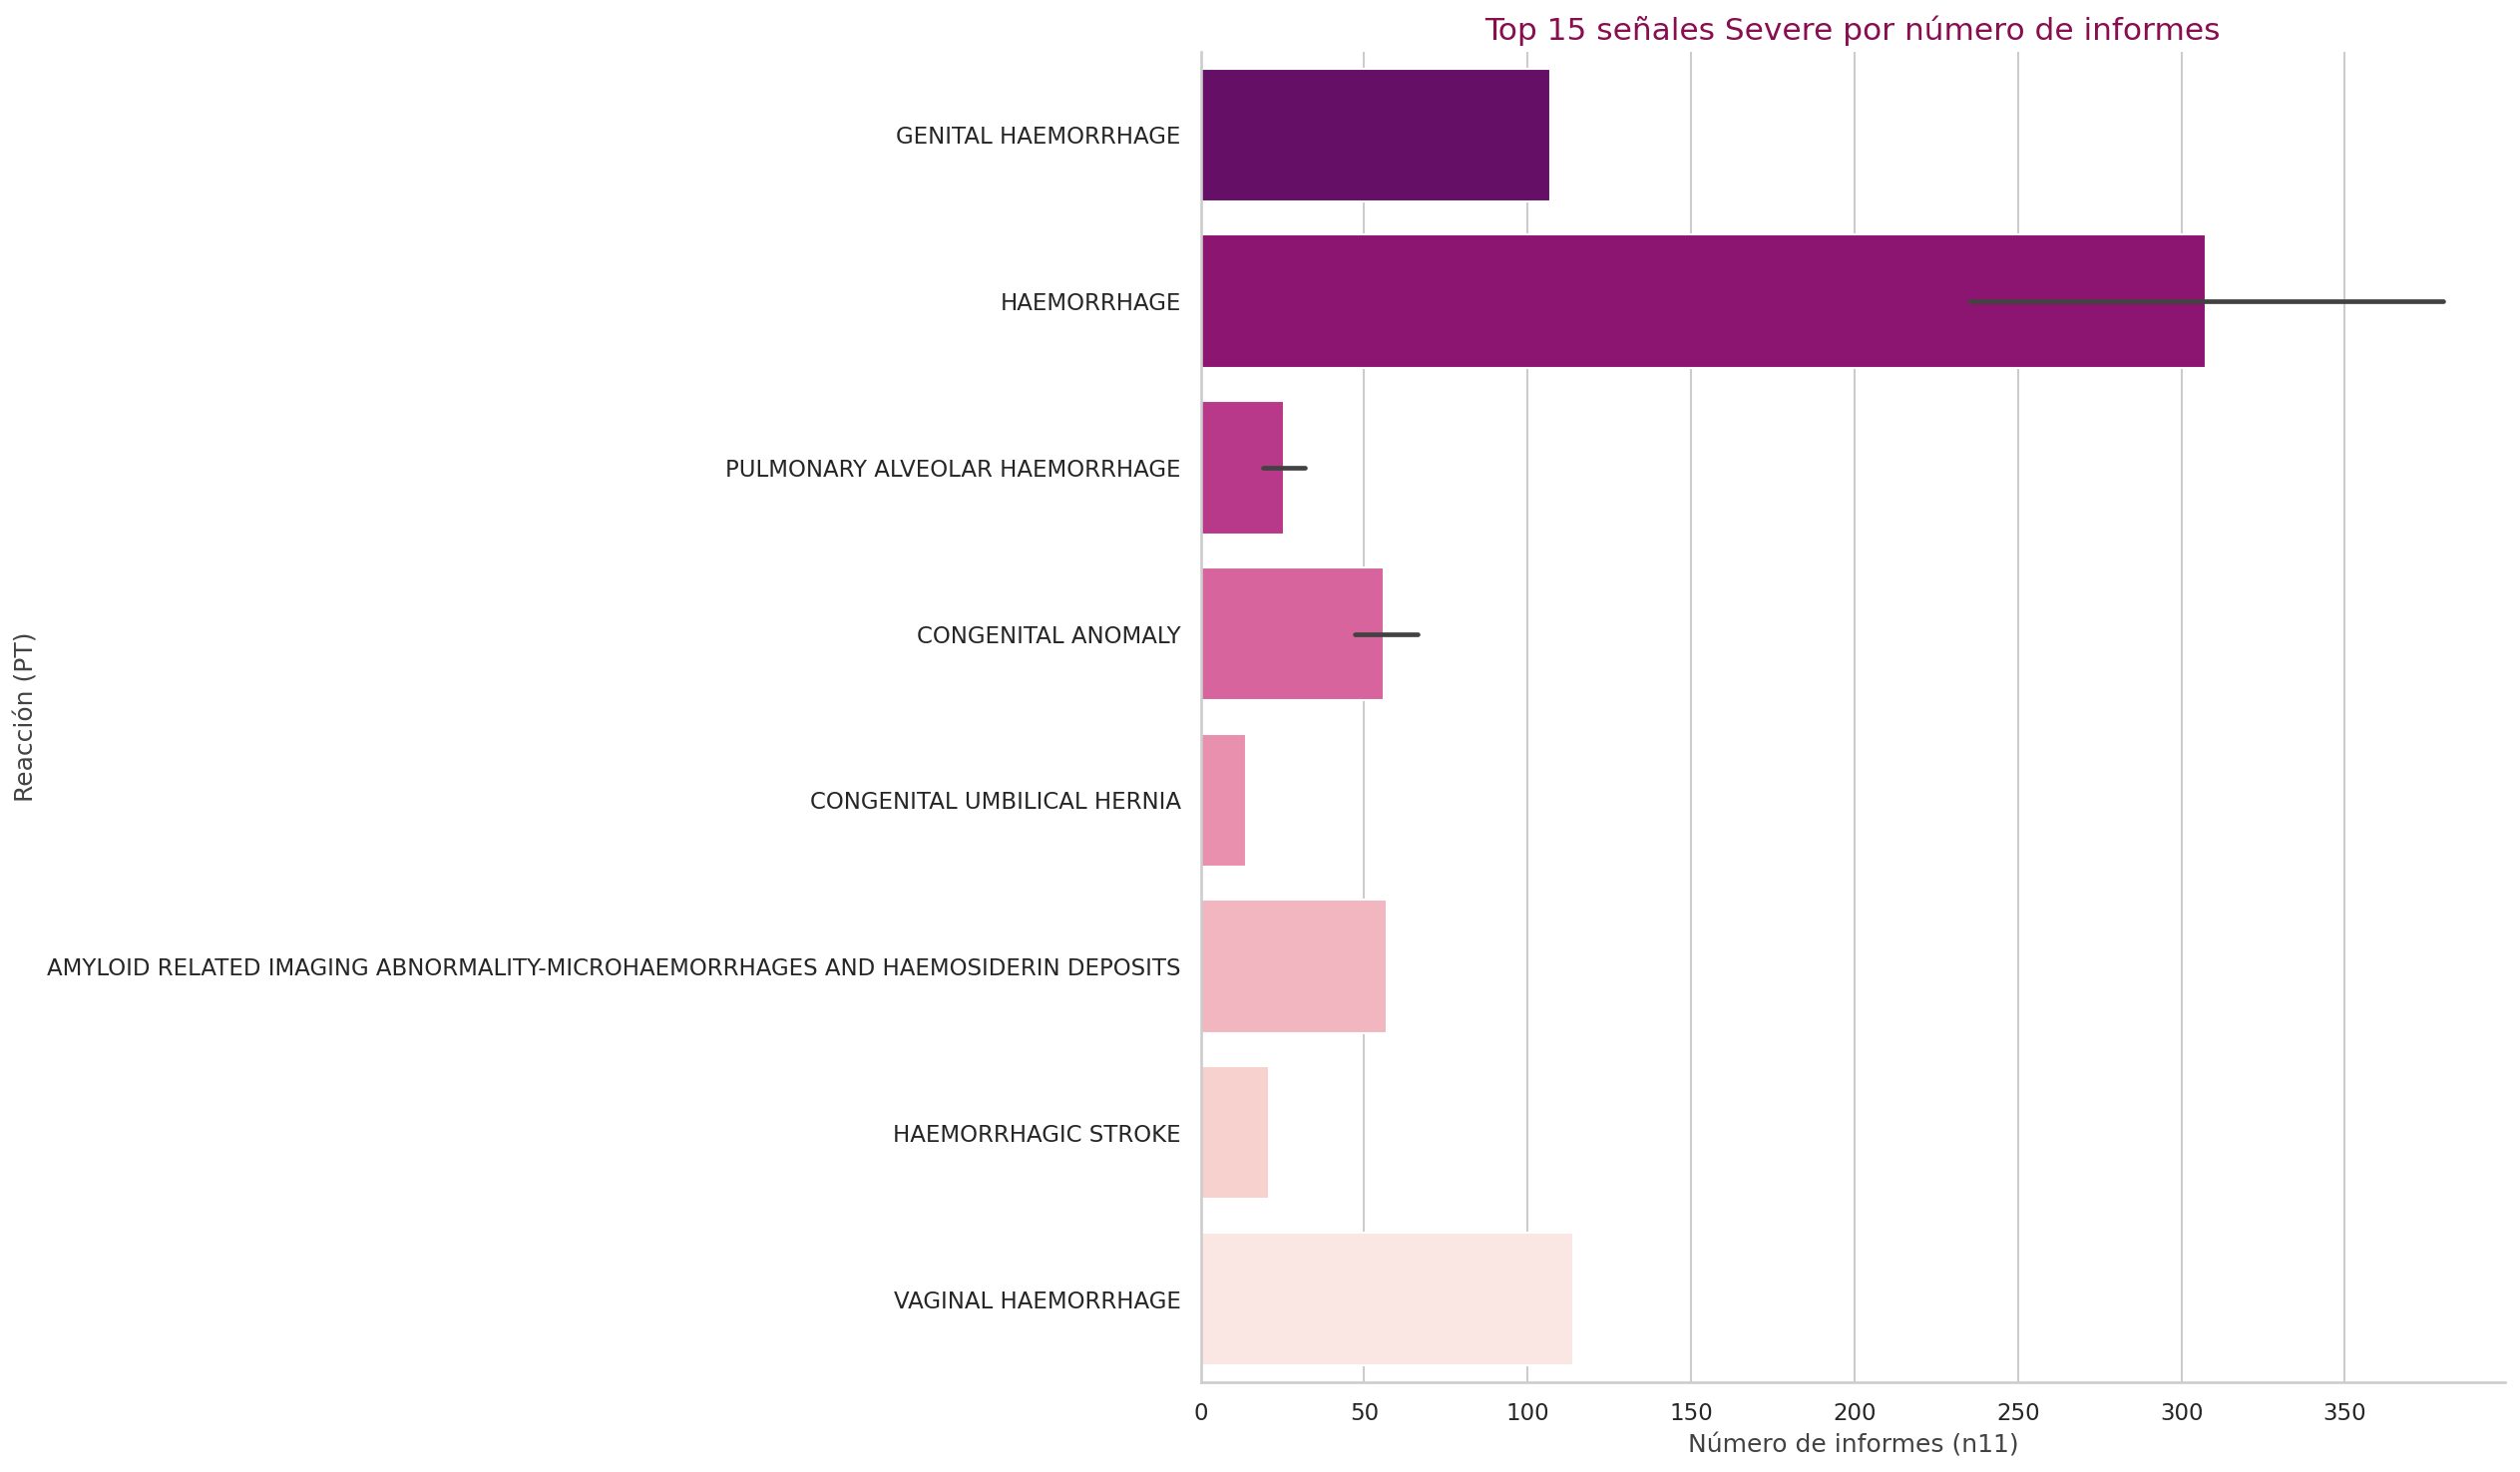

In [64]:
top_severe_plot = top_severe.head(15).copy()

plt.figure(figsize=(17, 10), dpi=150)

sns.barplot(
    data=top_severe_plot, 
    x="n11", 
    y="reaction_pt", 
    palette="RdPu_r",  # El '_r' es para que el más fuerte esté arriba
    hue="reaction_pt", 
    legend=False
)

plt.title("Top 15 señales Severe por número de informes", fontsize=15, color="#880E4F")

plt.xlabel("Número de informes (n11)", fontsize=12, color="#424242")
plt.ylabel("Reacción (PT)", fontsize=12, color="#424242")
sns.despine()
plt.tight_layout()

plt.show()

In [65]:
top_moderate = (
    sig_pos_main[sig_pos_main["severity_category"] == "Moderate/Mild"]
    .sort_values("priority_score", ascending=False)
    .head(50)
)
top_moderate[["drug_key", "reaction_pt", "n11", "ROR_L95", "priority_score"]].head(10)

,drug_key,reaction_pt,n11,ROR_L95,priority_score
477049,DESOXIMETASONE,SLEEP DISORDER DUE TO GENERAL MEDICAL CONDITIO...,225,588.597114,34.542491
1234627,PHTHALYLSULFATHIAZOLE,SLEEP DISORDER DUE TO GENERAL MEDICAL CONDITIO...,202,635.073826,34.258186
353437,CHLORHEXIDINE,SLEEP DISORDER DUE TO GENERAL MEDICAL CONDITIO...,148,765.800893,33.186098
1437330,SULFAMETHOXAZOLE,SLEEP DISORDER DUE TO GENERAL MEDICAL CONDITIO...,161,622.643461,32.693624
355409,CHLORHEXIDINE GLUCONATE\ISOPROPYL ALCOHOL,SLEEP DISORDER DUE TO GENERAL MEDICAL CONDITIO...,154,616.070034,32.354163
475777,DESOGESTREL\ETHINYL ESTRADIOL,SLEEP DISORDER DUE TO GENERAL MEDICAL CONDITIO...,127,726.641343,31.915602
682147,FLUMETHASONE PIVALATE,SLEEP DISORDER DUE TO GENERAL MEDICAL CONDITIO...,160,504.223865,31.582910
898388,LEFLUNOMIDE,SLEEP DISORDER DUE TO GENERAL MEDICAL CONDITIO...,235,320.188665,31.495860
348705,CETIRIZINE HYDROCHLORIDE\PSEUDOEPHEDRINE HYDRO...,SLEEP DISORDER DUE TO GENERAL MEDICAL CONDITIO...,164,471.156988,31.390654
354446,CHLORHEXIDINE GLUCONATE,SLEEP DISORDER DUE TO GENERAL MEDICAL CONDITIO...,170,421.293588,31.037325


In [66]:
#aqui el top al prinicipio vuelve a se muy similar a excepción de algunos 

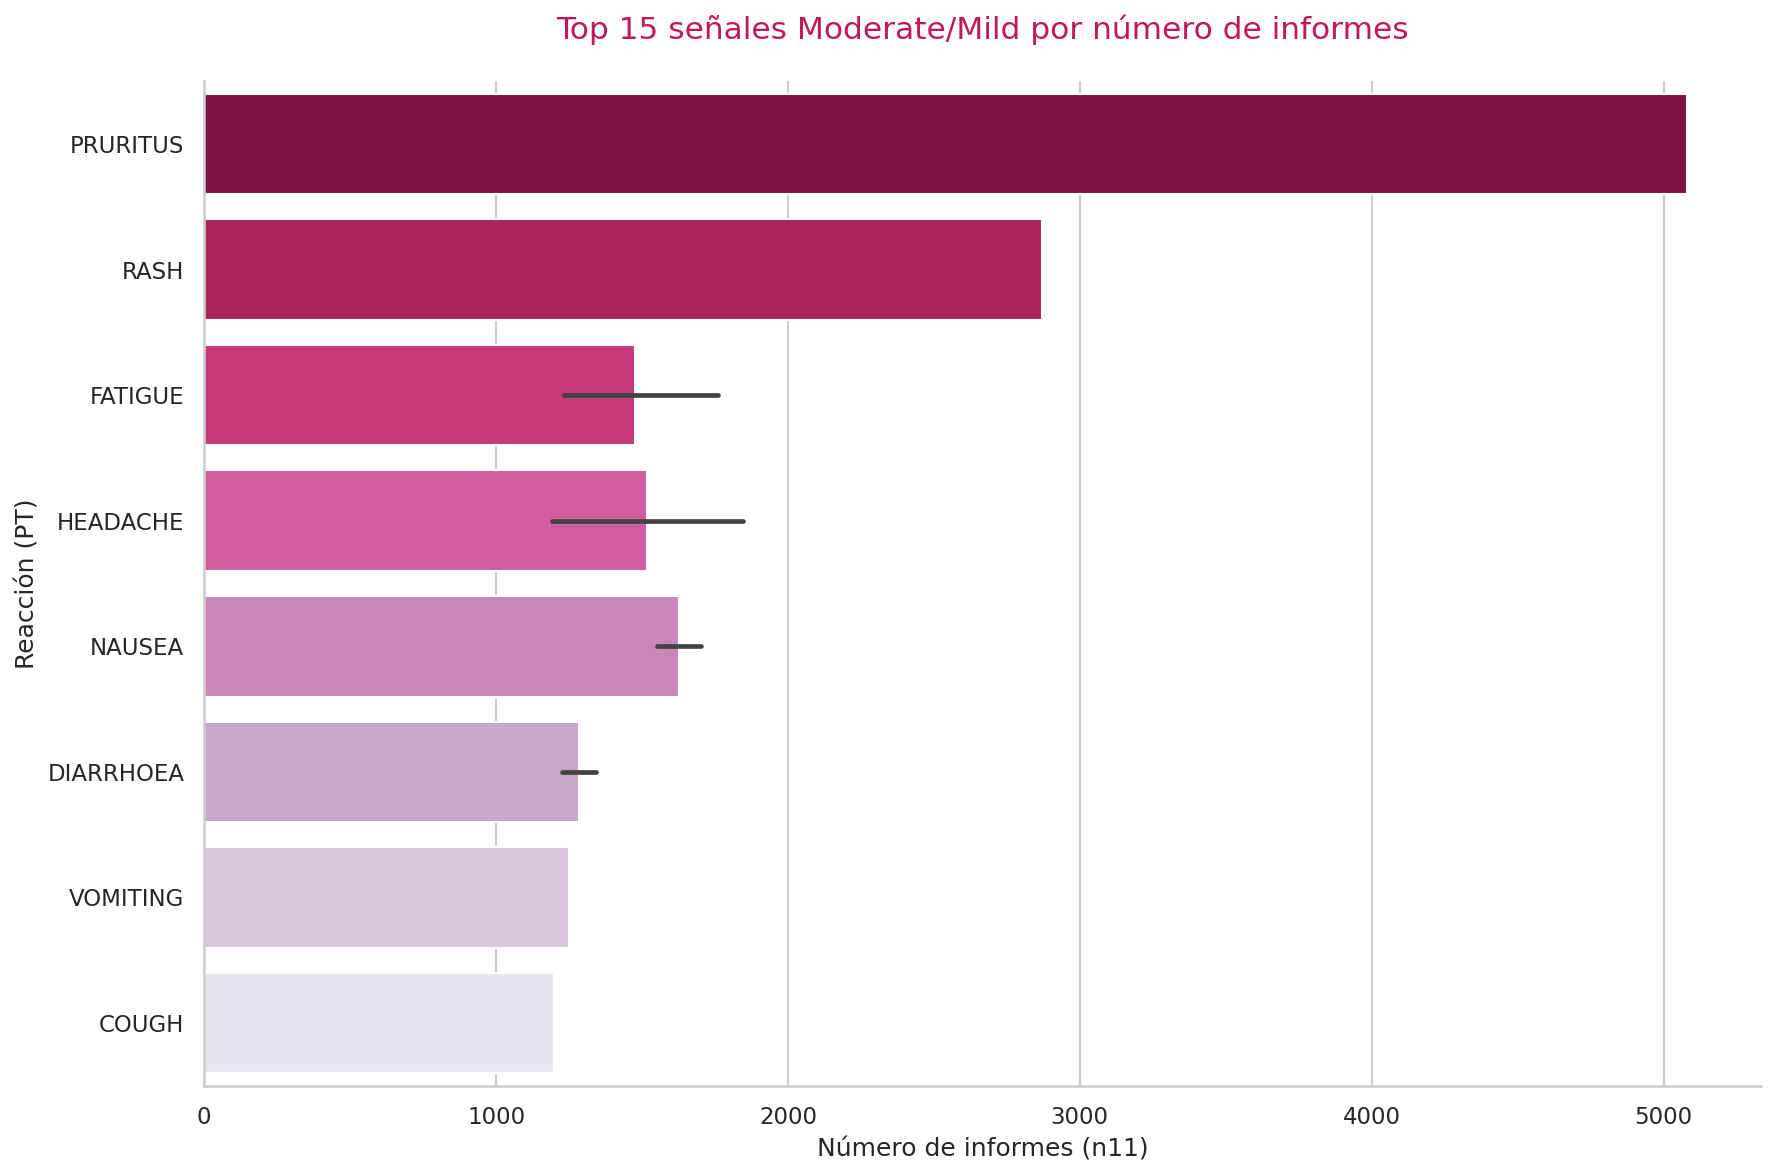

In [68]:
top_moderate = sig_pos_clin[sig_pos_clin["severity_category"] == "Moderate/Mild"].sort_values("n11", ascending=False)
top_moderate_plot = top_moderate.head(15).copy()
plt.figure(figsize=(12, 8), dpi=150)

sns.barplot(
    data=top_moderate_plot, 
    x="n11", 
    y="reaction_pt", 
    palette="PuRd_r",  # El '_r' pone el color más intenso en la barra más larga
    hue="reaction_pt", # Esto evita que Python te mande avisos de advertencia
    legend=False
)

plt.title("Top 15 señales Moderate/Mild por número de informes", fontsize=15, color="#C2185B", pad=20)
plt.xlabel("Número de informes (n11)", fontsize=12)
plt.ylabel("Reacción (PT)", fontsize=12)
sns.despine()
plt.tight_layout()

plt.show()

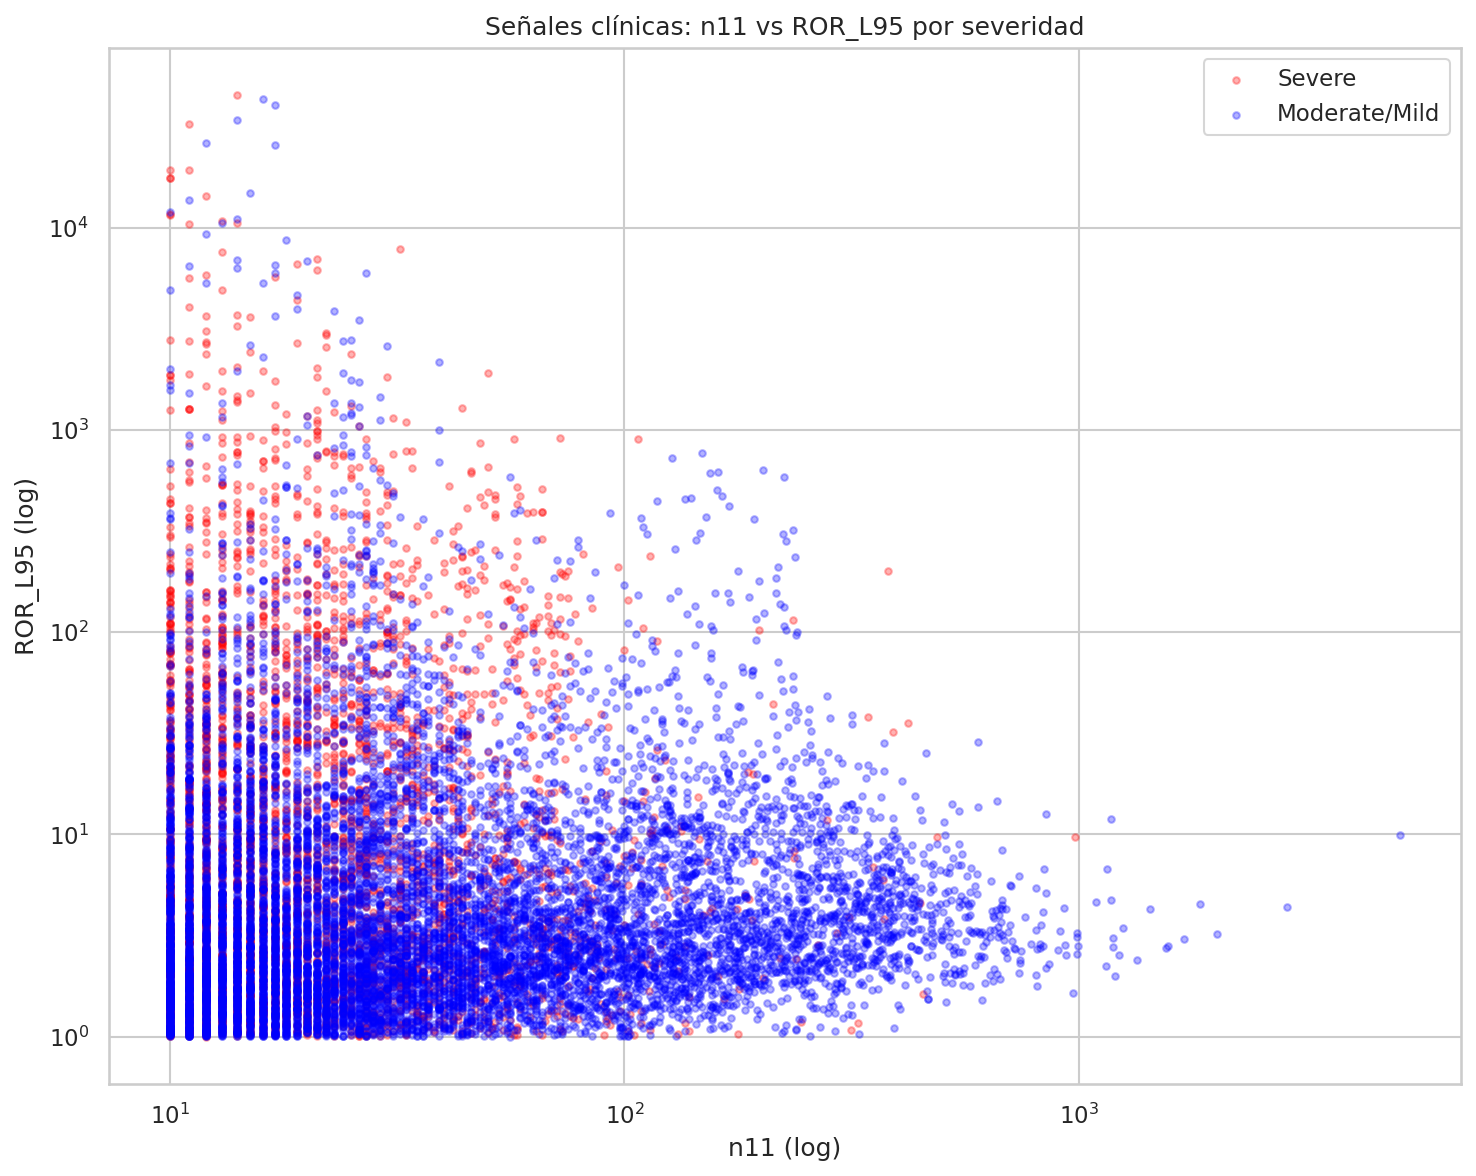

In [69]:
import numpy as np

plt.figure(figsize=(10, 8),dpi=150)
for sev, color in [("Severe", "red"), ("Moderate/Mild", "blue")]:
    sub = sig_pos_main[sig_pos_main["severity_category"] == sev]
    plt.scatter(sub["n11"], sub["ROR_L95"], alpha=0.3, s=10, label=sev, c=color)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("n11 (log)")
plt.ylabel("ROR_L95 (log)")
plt.title("Señales clínicas: n11 vs ROR_L95 por severidad")
plt.legend()
plt.tight_layout()
plt.show()

In [70]:
#La nube de puntos azul MILD domina la parte inferior lo que nos dice que los sintomas ocurren  muchisimas veces
#pero la fuerza estadistica es baja, lo rojo que es SEVERE por otro lado ocurre menor numero de veces pero su probabilidad es alta 
#tan alta que llega hasta la parte superior
#Existe superposioción, no podemos basarnos solo en un métrica.

In [71]:
#PERFIL POR FÁRMACO

In [72]:
drug_summary = (
    sig_pos_main
    .groupby(["drug_key", "severity_category"])
    .agg(n_signals=("reaction_pt", "nunique"))
    .reset_index()
)

drug_total = (
    drug_summary
    .groupby("drug_key")["n_signals"].sum()
    .rename("total_signals")
    .reset_index()
)

drug_severe = (
    drug_summary[drug_summary["severity_category"]=="Severe"]
    .rename(columns={"n_signals": "severe_signals"})[["drug_key", "severe_signals"]]
)

drug_profile = (
    drug_total.merge(drug_severe, on="drug_key", how="left")
)

drug_profile["severe_signals"] = drug_profile["severe_signals"].fillna(0)
drug_profile["severe_ratio"] = drug_profile["severe_signals"] / drug_profile["total_signals"]

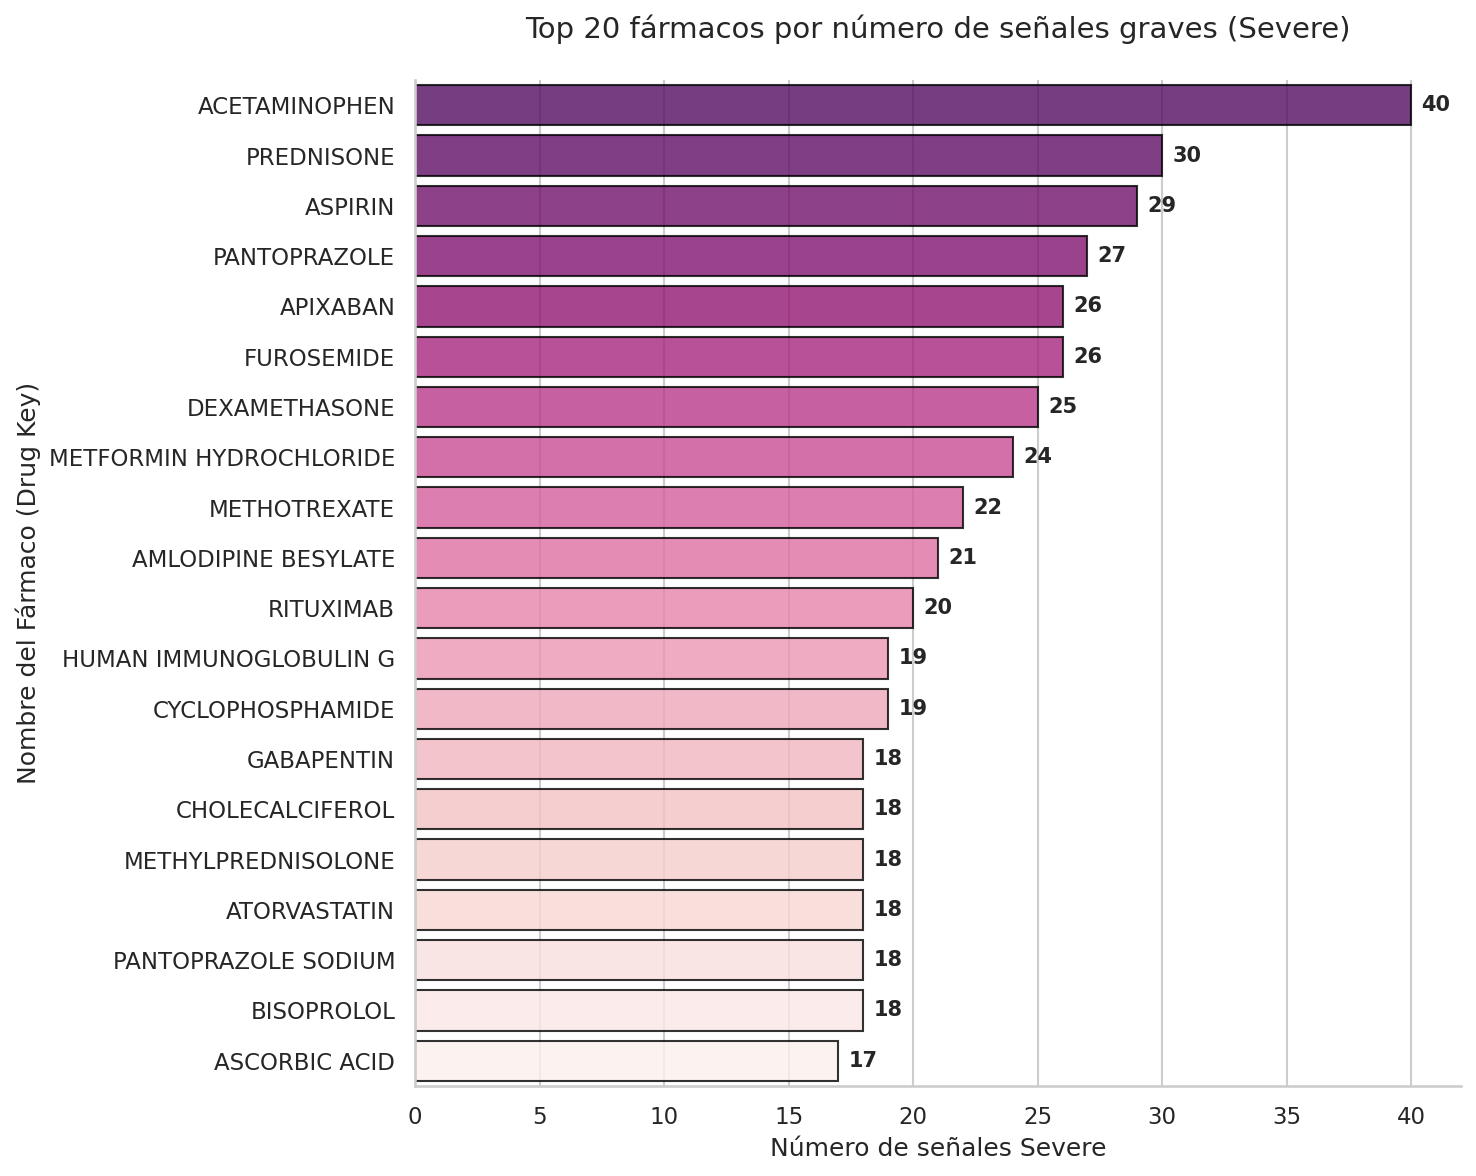

In [74]:
top_drugs_severe = drug_profile.sort_values("severe_signals", ascending=False).head(20)
plt.figure(figsize=(10, 8), dpi=150)
sns.set_theme(style="whitegrid")

ax = sns.barplot(
    data=top_drugs_severe, 
    x="severe_signals", 
    y="drug_key", 
    palette="RdPu_r", 
    hue="drug_key", 
    legend=False,
    edgecolor="black", # Agregamos un borde fino a las barras para que resalten
    alpha=0.8
)

plt.title("Top 20 fármacos por número de señales graves (Severe)", fontsize=14, pad=20)
plt.xlabel("Número de señales Severe", fontsize=12)
plt.ylabel("Nombre del Fármaco (Drug Key)", fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha = 'left', va = 'center', 
                xytext = (5, 0), 
                textcoords = 'offset points',
                fontsize=10, fontweight='bold')

sns.despine()
plt.tight_layout()
plt.show()

In [75]:
#el algoritmo detectó 40 señales de seguridad distintas que fueron clasificadas como "Severe" para ACETAMINOPHEN
#aqui ya el top severe se va pareciendo mas a los datos del profe.

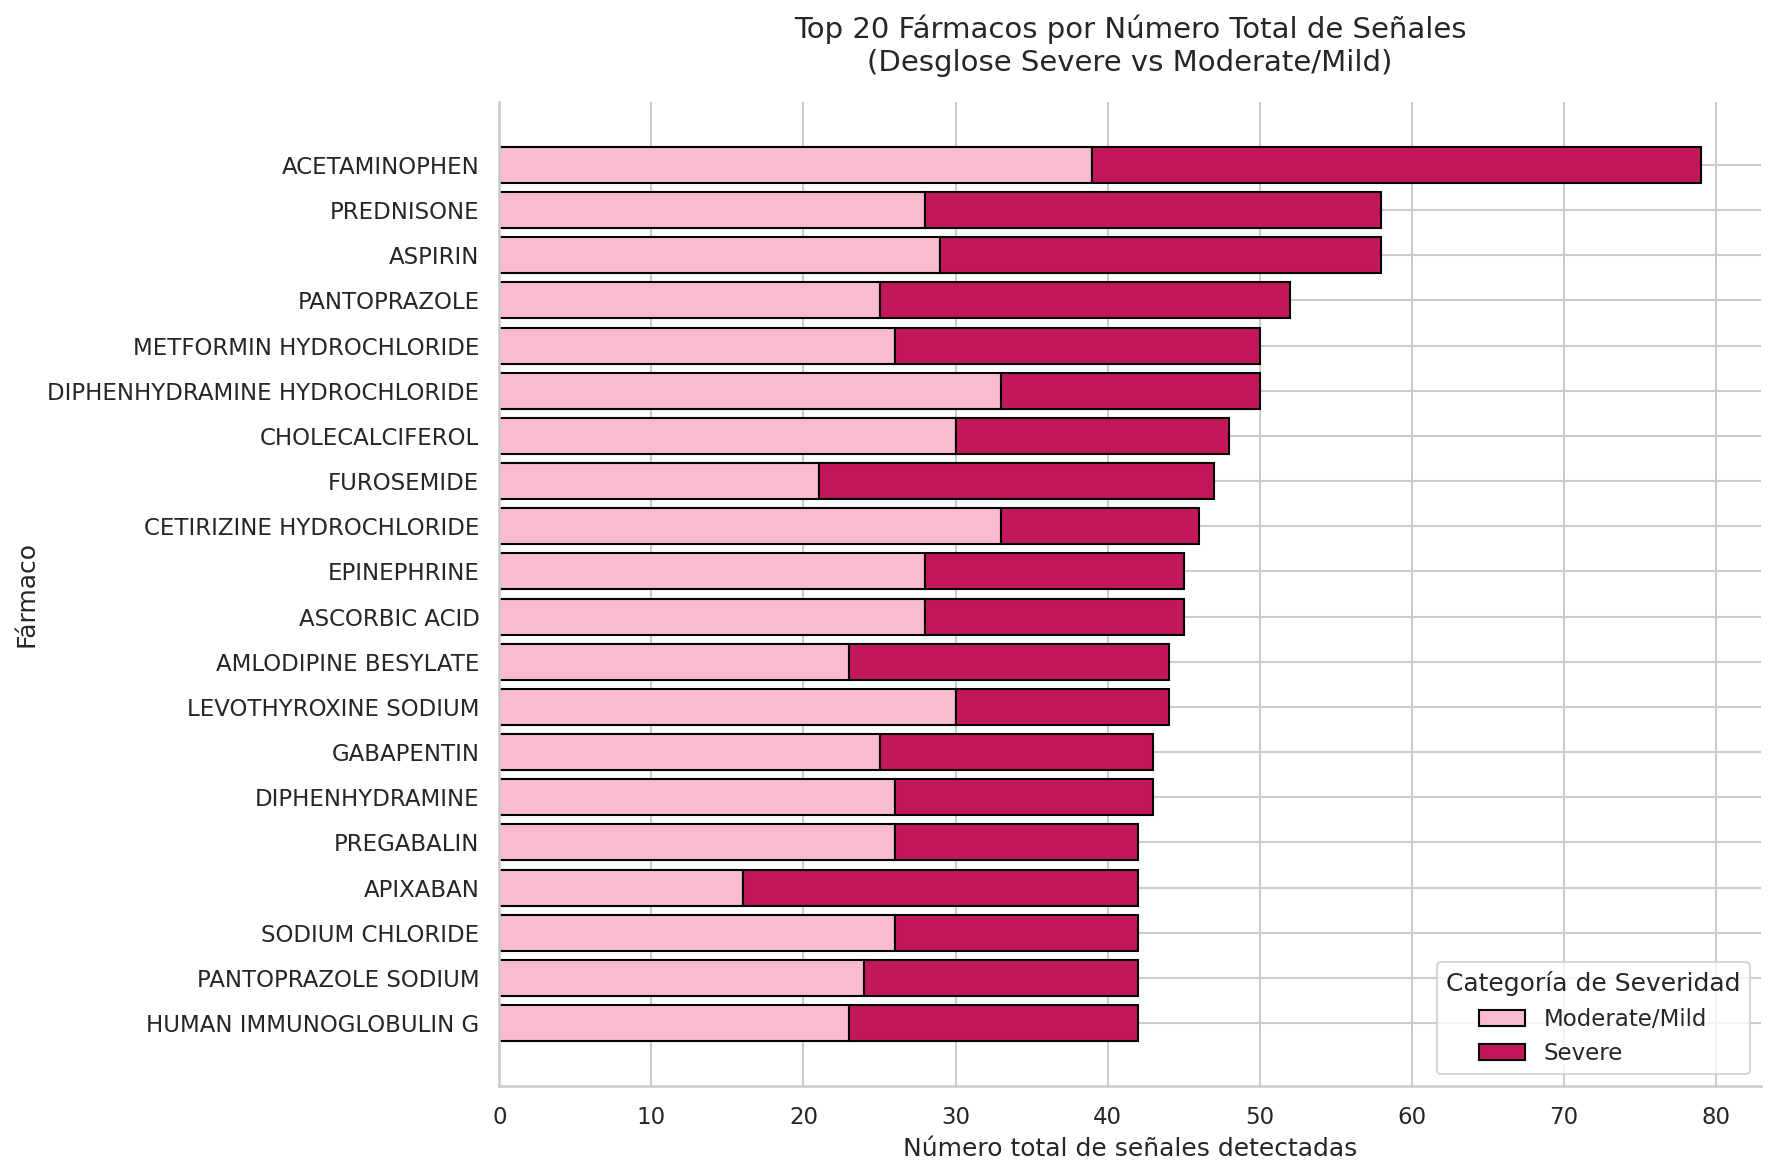

In [76]:
#agrupamos los datos por fármaco y gravedad para contar cuántas señales únicas tiene cada uno
drug_sev_long = sig_pos_main.groupby(["drug_key", "severity_category"]).agg(n_signals=("reaction_pt", "nunique")).reset_index()

#obtenemos la lista de los 20 fármacos que tienen más señales en total (sin importar la gravedad)
top_total_drugs = drug_profile.sort_values("total_signals", ascending=False).head(20)["drug_key"]
#para poder encimar las barras 
plot_data = drug_sev_long[drug_sev_long["drug_key"].isin(top_total_drugs)].pivot(index="drug_key", columns="severity_category", values="n_signals").fillna(0).loc[top_total_drugs]
plt.figure(figsize=(12, 8), dpi=150)
sns.set_theme(style="whitegrid") # Ponemos el fondo de cuadrícula blanca

plt.barh(plot_data.index, plot_data["Moderate/Mild"], label="Moderate/Mild", color="#F8BBD0", edgecolor="black")
plt.barh(plot_data.index, plot_data["Severe"], left=plot_data["Moderate/Mild"], label="Severe", color="#C2185B", edgecolor="black")

plt.gca().invert_yaxis()

plt.title("Top 20 Fármacos por Número Total de Señales\n(Desglose Severe vs Moderate/Mild)", fontsize=14, pad=15)
plt.xlabel("Número total de señales detectadas", fontsize=12)
plt.ylabel("Fármaco", fontsize=12)

plt.legend(title="Categoría de Severidad", frameon=True, facecolor="white")

sns.despine()
plt.tight_layout()
plt.show()

In [77]:
#Aqui de igual forma podemos observar que la mayoria es de efectos adversos moderados 

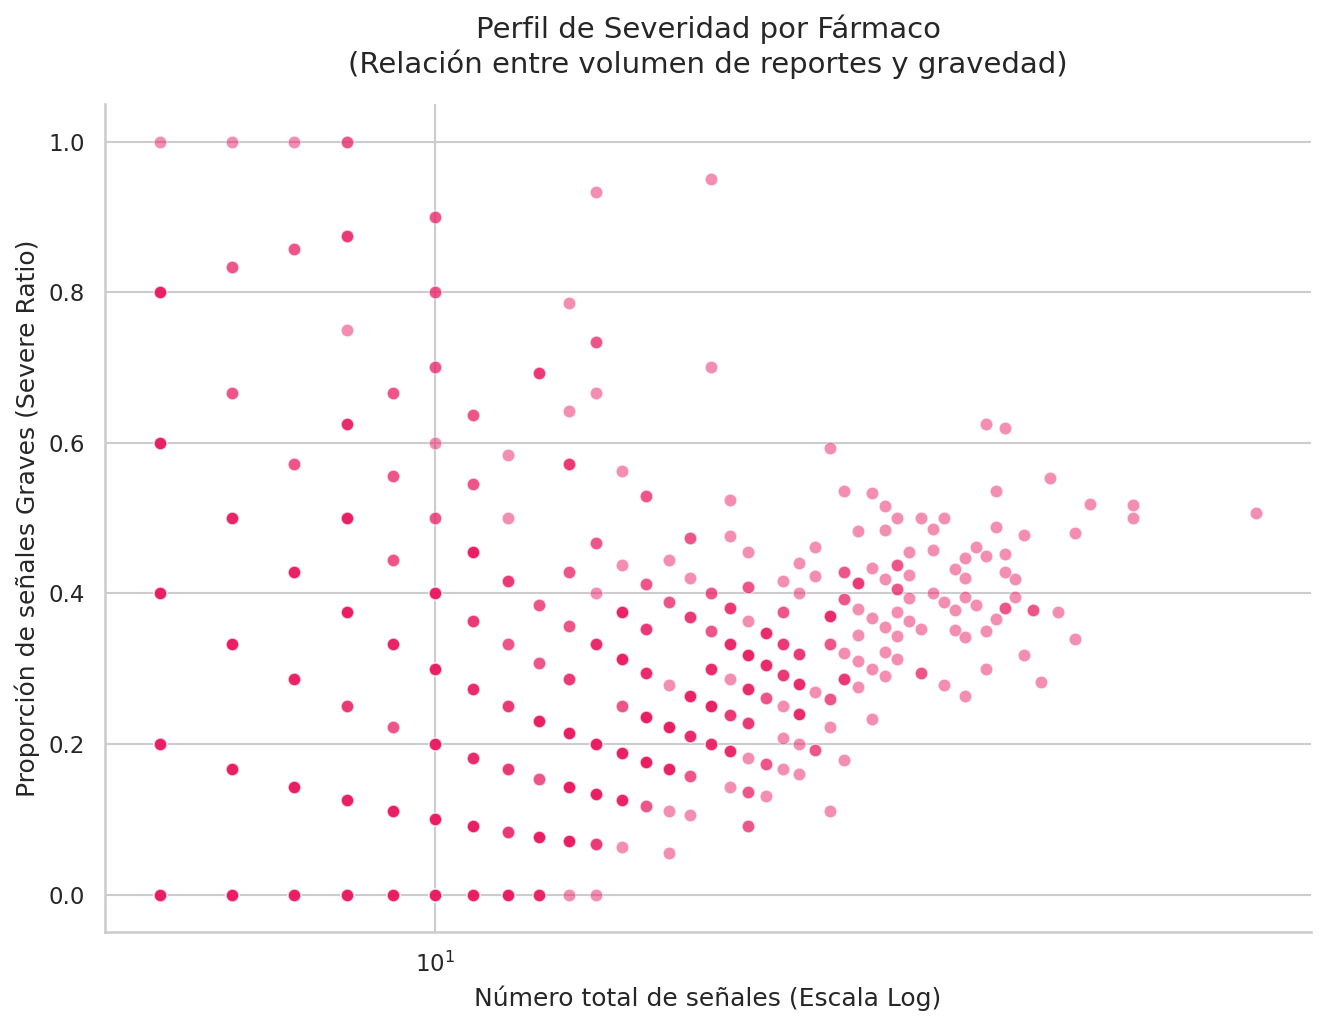

In [79]:
df_scatter = drug_profile[drug_profile["total_signals"] >= 5].copy()
plt.figure(figsize=(9, 7), dpi=150)
sns.set_theme(style="whitegrid")

sns.scatterplot(
    data=df_scatter, 
    x="total_signals", 
    y="severe_ratio", 
    color="#E91E63", 
    alpha=0.5, 
    edgecolor="white"
)

plt.xscale("log")

plt.xlabel("Número total de señales (Escala Log)", fontsize=12)
plt.ylabel("Proporción de señales Graves (Severe Ratio)", fontsize=12)
plt.title("Perfil de Severidad por Fármaco\n(Relación entre volumen de reportes y gravedad)", fontsize=14, pad=15)

sns.despine()
plt.tight_layout()
plt.show()

In [80]:
#El eje horizontal mide el volumenpor ais decirlo
#de señales generadas; entre más a la derecha se sitúa un fármaco, mayor es su presencia estadística en la base de datos, el eje 
#vertical representa la poporción de severidad un valor de 1.0 significa que la totalidad de sus señales son graves, mientras
#que 0.5 indica un equilibrio entre efectos moderados y severos, la nube de puntos se amontona mayoritariamente en la zona 
#de baja severidad, pero aquellos que escapan hacia el cuadrante superior son tus los alto riesgo


In [81]:
candidatos = df_scatter[
    (df_scatter["total_signals"] >= 50) & (df_scatter["severe_ratio"] >= 0.5)
].sort_values("severe_ratio", ascending=False)

candidatos

,drug_key,total_signals,severe_signals,severe_ratio
1214,PANTOPRAZOLE,52,27.0,0.519231
1314,PREDNISONE,58,30.0,0.517241
21,ACETAMINOPHEN,79,40.0,0.506329
146,ASPIRIN,58,29.0,0.500000


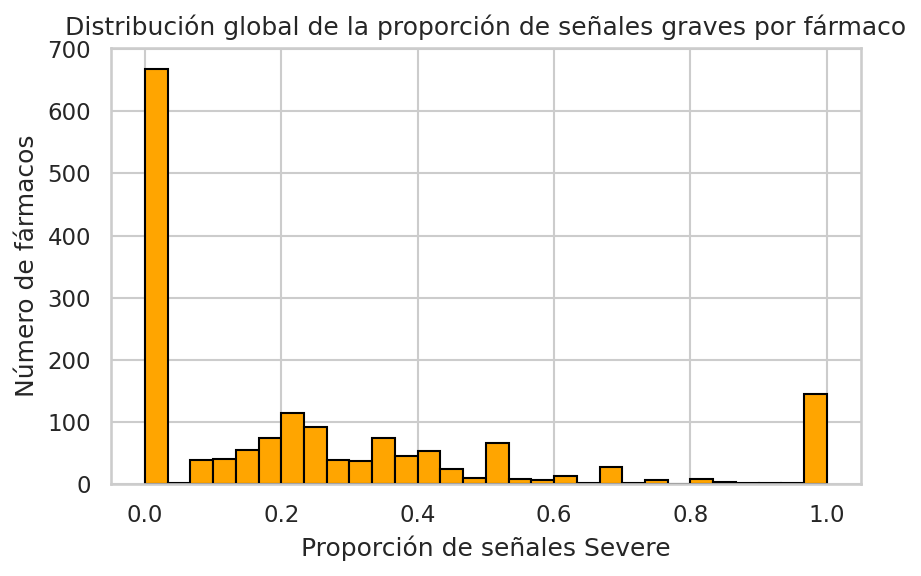

In [82]:
plt.figure(figsize=(6,4),dpi=150)
plt.hist(drug_profile["severe_ratio"], bins=30, edgecolor='black',color ='orange')
plt.xlabel("Proporción de señales Severe")
plt.ylabel("Número de fármacos")
plt.title("Distribución global de la proporción de señales graves por fármaco")
plt.tight_layout()
plt.show()

In [83]:
#Perfil por fármaco

In [84]:
reaction_sev = (
    sig_pos_main
    .groupby(["reaction_pt", "severity_category"])
    .agg(
        n_drugs=("drug_key", "nunique"),
        n_pairs=("drug_key", "size"),
        total_n11=("n11", "sum")
    )
    .reset_index()
)
reaction_sev.head()

,reaction_pt,severity_category,n_drugs,n_pairs,total_n11
0,ACUTE HEPATIC FAILURE,Severe,15,15,386
1,ACUTE MYOCARDIAL INFARCTION,Severe,33,33,607
2,ACUTE RESPIRATORY FAILURE,Severe,90,90,1595
3,AMYLOID RELATED IMAGING ABNORMALITY-MICROHAEMO...,Severe,2,2,103
4,ANAL HAEMORRHAGE,Severe,3,3,67


In [85]:
top_severe_reactions = (
    reaction_sev[reaction_sev["severity_category"] == "Severe"]
    .sort_values("n_drugs", ascending=False)
)
top_severe_reactions

,reaction_pt,severity_category,n_drugs,n_pairs,total_n11
112,SEPSIS,Severe,417,417,12862
107,RECTAL HAEMORRHAGE,Severe,327,327,12113
31,DEATH,Severe,317,317,17173
13,CARDIAC FAILURE,Severe,182,182,4746
109,RESPIRATORY FAILURE,Severe,165,165,3952
...,...,...,...,...,...
43,ENTEROCOCCAL SEPSIS,Severe,1,1,10
111,SARCOMATOID MESOTHELIOMA,Severe,1,1,12
99,PULMONARY HAEMORRHAGE,Severe,1,1,10
122,STOMA SITE HAEMORRHAGE,Severe,1,1,13


In [86]:
#AQUI lo que podemos ver en el ejemplo de SEPSIS es que 417 farmacos lo han causado y hay 12862 reportes sobre ello 

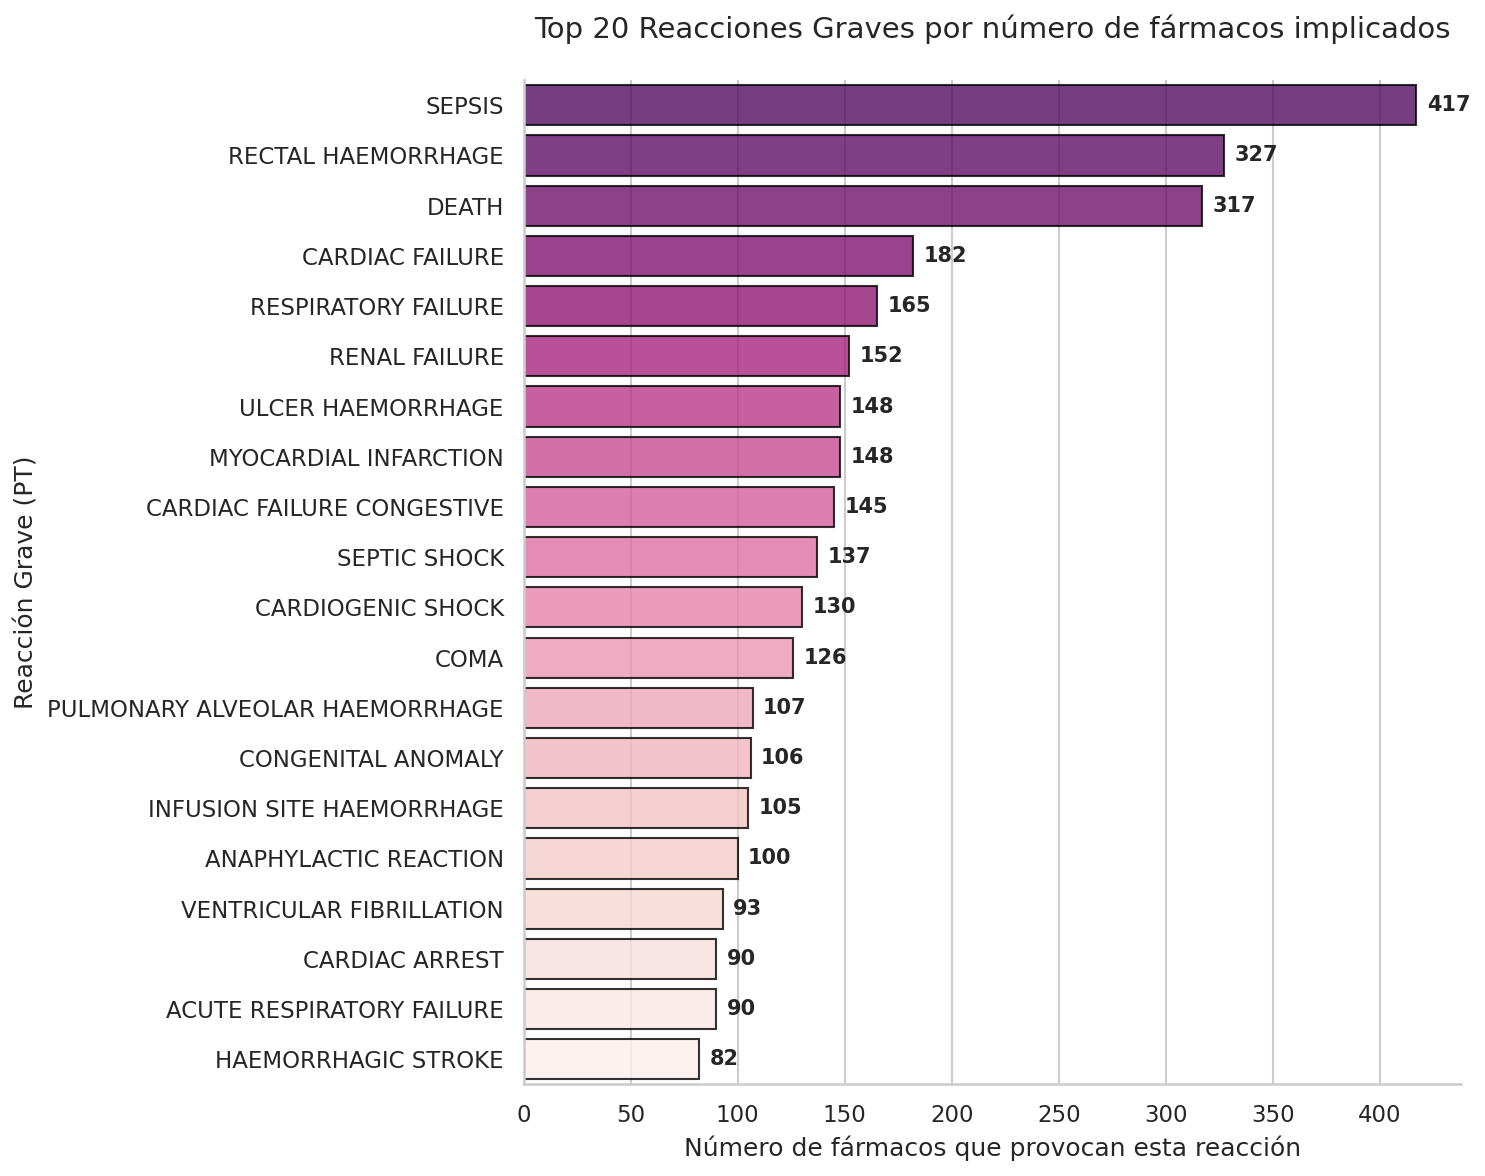

In [88]:
top_severe_reactions_drugs = reaction_sev[reaction_sev["severity_category"] == "Severe"].sort_values("n_drugs", ascending=False).head(20)
plt.figure(figsize=(10, 8), dpi=150)
sns.set_theme(style="whitegrid")

ax = sns.barplot(
    data=top_severe_reactions_drugs, 
    x="n_drugs", 
    y="reaction_pt", 
    palette="RdPu_r", 
    hue="reaction_pt", 
    legend=False,
    edgecolor="black", 
    alpha=0.8
)

plt.title("Top 20 Reacciones Graves por número de fármacos implicados", fontsize=14, pad=20)
plt.xlabel("Número de fármacos que provocan esta reacción", fontsize=12)
plt.ylabel("Reacción Grave (PT)", fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha = 'left', va = 'center', 
                xytext = (5, 0), 
                textcoords = 'offset points',
                fontsize=10, fontweight='bold')

sns.despine()
plt.tight_layout()
plt.show()

In [89]:
#ahora por numero de reportes

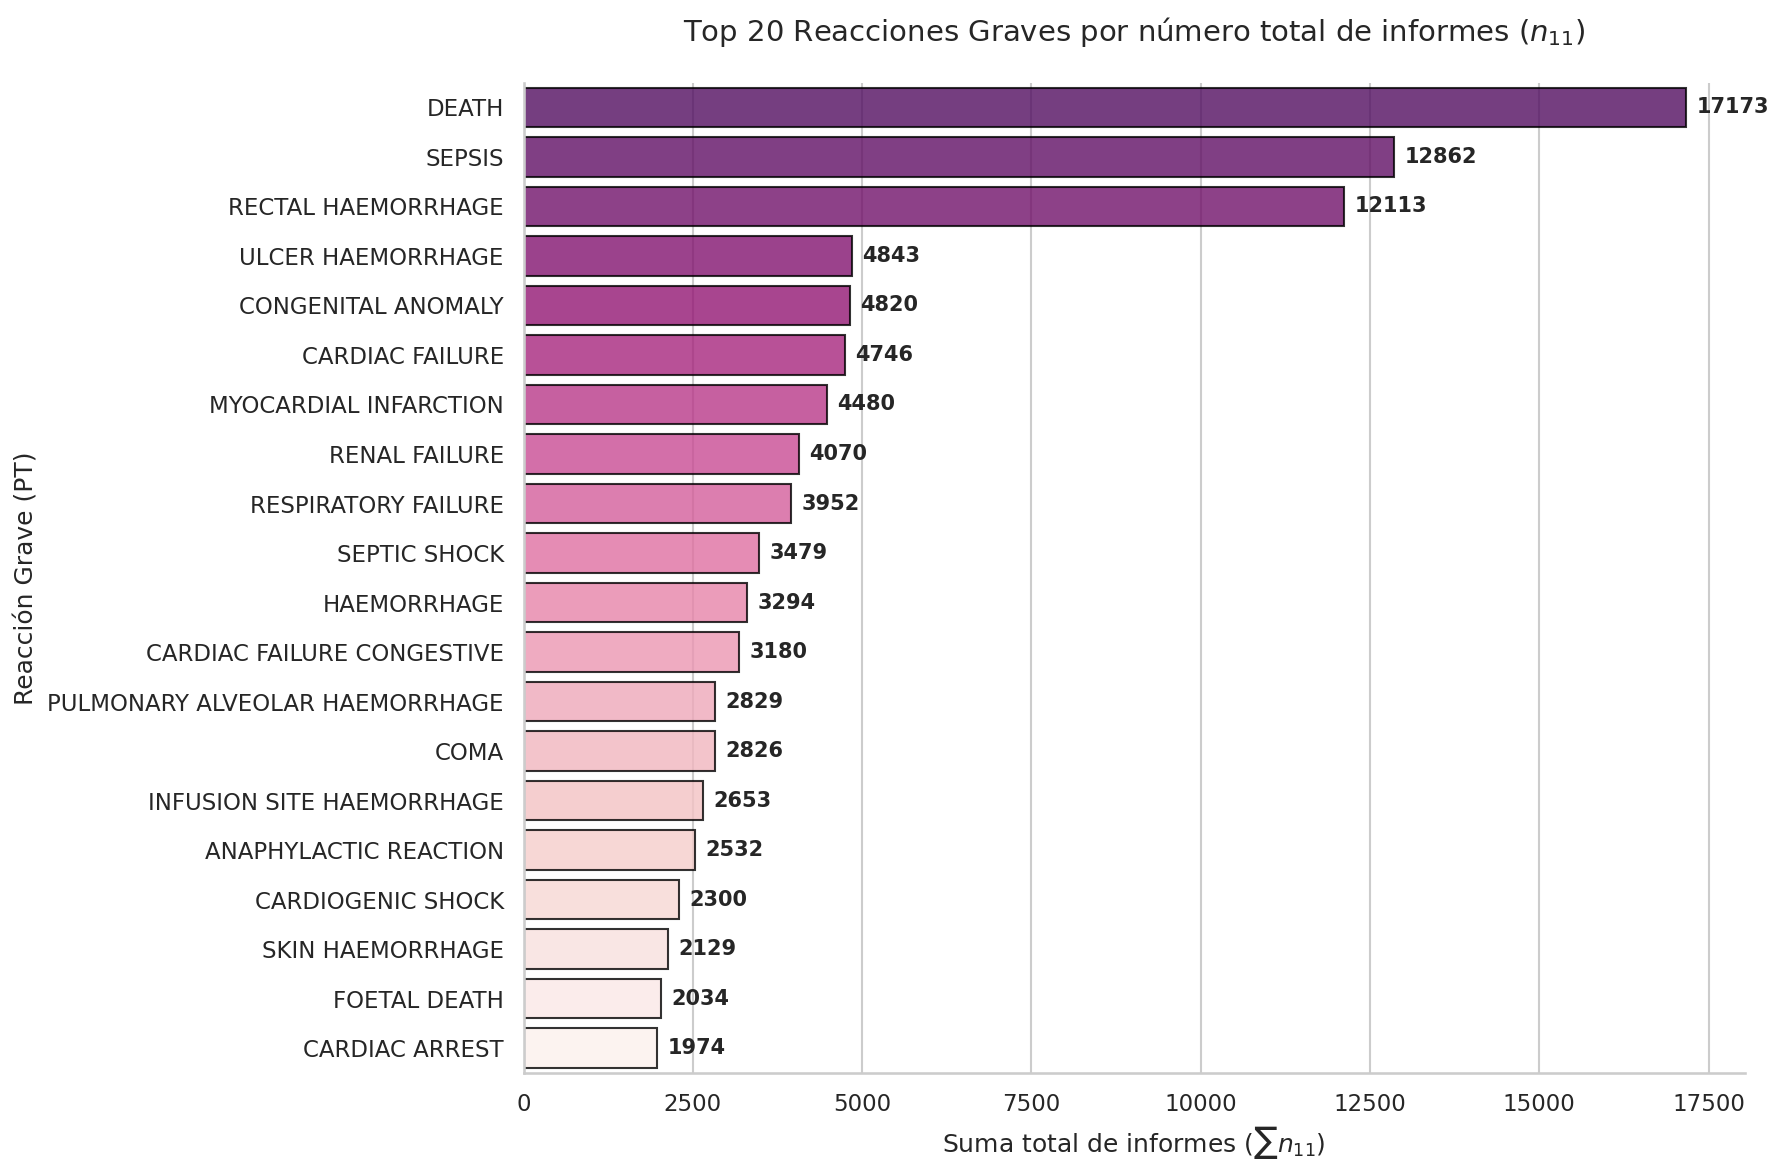

In [92]:
top_severe_reactions_n11 = reaction_sev[reaction_sev["severity_category"] == "Severe"].sort_values("total_n11", ascending=False).head(20)
plt.figure(figsize=(12, 8), dpi=150)
sns.set_theme(style="whitegrid")

ax = sns.barplot(
    data=top_severe_reactions_n11, 
    x="total_n11", 
    y="reaction_pt", 
    palette="RdPu_r", 
    hue="reaction_pt", 
    legend=False,
    edgecolor="black", 
    alpha=0.8
)

for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha = 'left', va = 'center', 
                xytext = (5, 0), 
                textcoords = 'offset points',
                fontsize=10, fontweight='bold')

plt.title(r"Top 20 Reacciones Graves por número total de informes ($n_{11}$)", fontsize=14, pad=20)
plt.xlabel(r"Suma total de informes ($\sum n_{11}$)", fontsize=12)
plt.ylabel("Reacción Grave (PT)", fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

In [93]:
# Reacciones con muchos pares (independientemente de severidad)
common_reactions = (
    reaction_sev
    .groupby("reaction_pt")["n_pairs"].sum()
    .reset_index()
)
common_reactions = common_reactions[common_reactions["n_pairs"] >= 50]

# Filtra reaction_sev a esas reacciones
reac_long = reaction_sev[
    reaction_sev["reaction_pt"].isin(common_reactions["reaction_pt"])
].copy()

pivot_reac = (
    reac_long
    .pivot(index="reaction_pt", columns="severity_category", values="n_pairs")
    .fillna(0)
)

pivot_reac["total_pairs"] = pivot_reac.sum(axis=1)
pivot_reac["severe_ratio"] = pivot_reac["Severe"] / pivot_reac["total_pairs"]

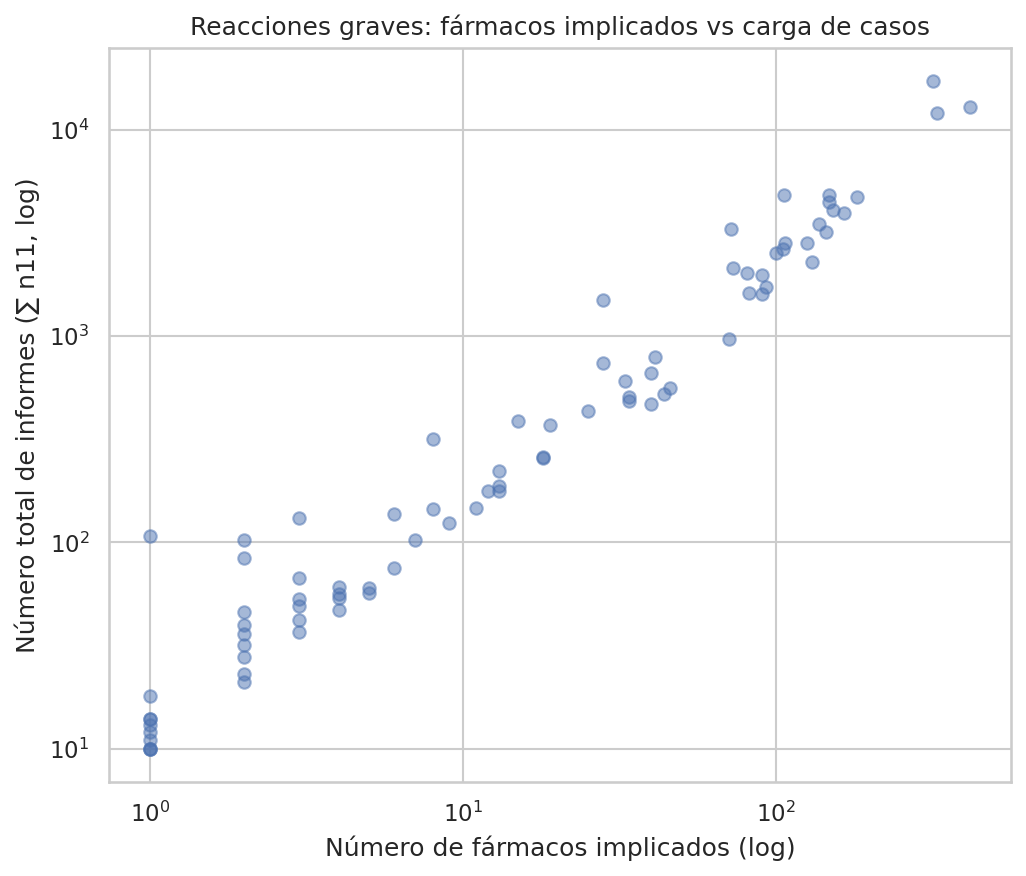

In [94]:
sev_reac = reaction_sev[reaction_sev["severity_category"] == "Severe"].copy()

plt.figure(figsize=(7, 6),dpi=150)
plt.scatter(sev_reac["n_drugs"], sev_reac["total_n11"], alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Número de fármacos implicados (log)")
plt.ylabel("Número total de informes (∑ n11, log)")
plt.title("Reacciones graves: fármacos implicados vs carga de casos")
plt.tight_layout()
plt.show()


#Tragedias como la muerte no son anormales ailadas, son problema del sistema de salud

In [95]:
hot_reac = sev_reac[
    (sev_reac["n_drugs"] >= 5) & (sev_reac["total_n11"] >= 200)
].sort_values("total_n11", ascending=False)
hot_reac

,reaction_pt,severity_category,n_drugs,n_pairs,total_n11
31,DEATH,Severe,317,317,17173
112,SEPSIS,Severe,417,417,12862
107,RECTAL HAEMORRHAGE,Severe,327,327,12113
128,ULCER HAEMORRHAGE,Severe,148,148,4843
25,CONGENITAL ANOMALY,Severe,106,106,4820
13,CARDIAC FAILURE,Severe,182,182,4746
84,MYOCARDIAL INFARCTION,Severe,148,148,4480
108,RENAL FAILURE,Severe,152,152,4070
109,RESPIRATORY FAILURE,Severe,165,165,3952
113,SEPTIC SHOCK,Severe,137,137,3479


In [96]:
#TERMINAMOS CON LAS REACCIONES CRITICAS AQUI PONEMOS QUE LA ENFERMEDAD SEA CAUSADA ALMENOS POR 5 Y EL VOLUMEN DE DAÑO POR LO MENOS A 200 PACIENTES